In [1]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [16]:
classificators = [
    ("LGBMClassifier", LGBMClassifier, SEARCH_SPACE_LGBM, LIGHTGBM_PARAMS),
    ("XGBClassifier", XGBClassifier, SEARCH_SPACE_XGB, XGBOOST_PARAMS),
    ("TABNETClassifier", TabNetClassifier, SEARCH_SPACE_TABNET, TABNET_PARAMS),
]

In [17]:
def BayesianOptimization(clf, params, search_range, model_name):
    def func_gb(values):
        for i, param in enumerate(search_range):
            params[param.name] = values[i]
            if param.name == "n_a":
                params["n_d"] = values[i]
        print('\nTesting next set of paramaters...', params)

        model = clf(**params)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric=["auc"], early_stopping_rounds=10, verbose=0)
        neg_auc = round(-roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]), 8)

        print('AUC: ', -neg_auc, ' of boosting iteration ')
        return neg_auc
    
    def func_tabnet(values):
        for i, param in enumerate(search_range):
            params[param.name] = values[i]
            if param.name == "n_a":
                params["n_d"] = values[i]
        print('\nTesting next set of paramaters...', params)

        model = clf(**params)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric=["auc"], max_epochs=40)
        neg_auc = round(-roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]), 8)

        print('AUC: ', -neg_auc, ' of boosting iteration ')
        return neg_auc
    
    return func_gb if model_name != "TABNETClassifier" else func_tabnet

In [18]:
datasets = ["syn" + str(i + 1) for i in range(6)]

In [34]:
for dataset in datasets:
    print("STARTED:", dataset)
    train = pd.read_csv("data/synthetic/{}/train.csv".format(dataset))
    valid = pd.read_csv("data/synthetic/{}/val.csv".format(dataset))
    
    train_x = train.drop(["TARGET"], axis=1).values
    train_y = train["TARGET"].values
    
    valid_x = valid.drop(["TARGET"], axis=1).values
    valid_y = valid["TARGET"].values

    results = dict()
    for clf_name, clf, search_range, params in classificators:
        res_gp = gp_minimize(BayesianOptimization(clf, params, search_range, clf_name), search_range, n_jobs=-1, verbose=True, n_initial_points=30, n_calls=30)
        results[clf_name] = res_gp
        with open('{}_hp_kdd_{}.pickle'.format(clf_name, dataset), 'wb') as f:
            pickle.dump(res_gp.x, f)

STARTED: syn1
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.12084853580348885, 'max_depth': 14, 'n_estimators': 630}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  1.0  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0464
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.34145281732771193, 'max_depth': 5, 'n_estimators': 434}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves.

AUC:  1.0  of boosting iteration 
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.0450
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.2832805429127948, 'max_depth': 11, 'n_estimators': 874}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  1.0  of boosting iteration 
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.0431
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.493912741371

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99999467  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1983
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.34850575442384213, 'max_depth': 11, 'n_estimators': 199}
[01:10:08] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.9998364  of boosting iteration 
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1344
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at ra

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99999467  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1377
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6394450279970071, 'max_depth': 4, 'n_estimators': 627}
[01:10:08] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99974214  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1387
Function value obtained: -0.9997
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at ran

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  1.0  of boosting iteration 
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1479
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9529419512873549, 'max_depth': 3, 'n_estimators': 256}
[01:10:08] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99991464  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.0910
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random poi

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4797853231270728, 'max_depth': 7, 'n_estimators': 391}
[01:10:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  1.0  of boosting iteration 
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.1552
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.3050652650602069, 'max_depth': 10, 'n_estimators': 468}
[01:10:09] WARNING: ../src/learner.cc:541: 
Paramete

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99977415  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.1500
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8678227780345608, 'max_depth': 11, 'n_estimators': 778}
[01:10:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99999822  of boosting iteration 
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.1309
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  1.0  of boosting iteration 
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.1128
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4817383987106695, 'max_depth': 8, 'n_estimators': 921}
[01:10:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99983462  of boosting iteration 
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.1322
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99998755  of boosting iteration 
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.1080
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.49127775700776555, 'max_depth': 10, 'n_estimators': 909}
[01:10:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99993954  of boosting iteration 
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.1201
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-

AUC:  0.99972081  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.1042
Function value obtained: -0.9997
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7279743302983198, 'max_depth': 6, 'n_estimators': 477}
[01:10:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99998933  of boosting iteration 
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.0942
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99981328  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.2753
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.45207641657894415, 'max_depth': 10, 'n_estimators': 932}
[01:10:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99993776  of boosting iteration 
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.1105
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99968524  of boosting iteration 
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.2625
Function value obtained: -0.9997
Current minimum: -1.0000
Iteration No: 21 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.24849547796029128, 'max_depth': 6, 'n_estimators': 797}
[01:10:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99913218  of boosting iteration 
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 0.1616
Function value obtained: -0.9991
Current minimum: -1.0000
Iteration No: 22 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99991642  of boosting iteration 
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.2467
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 23 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4947955597957918, 'max_depth': 10, 'n_estimators': 765}
[01:10:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99999822  of boosting iteration 
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 0.1535
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  1.0  of boosting iteration 
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.0899
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.18177356452368387, 'max_depth': 15, 'n_estimators': 138}
[01:10:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.999623  of boosting iteration 
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.1841
Function value obtained: -0.9996
Current minimum: -1.0000
Iteration No: 26 started. Evaluating function at random

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99979816  of boosting iteration 
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 0.1548
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 27 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.14048775656067247, 'max_depth': 12, 'n_estimators': 683}
[01:10:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99967635  of boosting iteration 
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.1246
Function value obtained: -0.9997
Current minimum: -1.0000
Iteration No: 28 started. Evaluating function 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99998933  of boosting iteration 
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 0.1151
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5904366014037258, 'max_depth': 13, 'n_estimators': 833}
[01:10:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99999111  of boosting iteration 
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 0.1380
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Iteration No: 30 ended. Evaluation done at random point.
Time taken: 1.0966
Function value obtained: -0.5044
Current minimum: -1.0000
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.8294789242800777, 'lambda_sparse': 0.024825767831183742, 'n_steps': 3, 'n_a': 8, 'n_d': 8, 'momentum': 0.7}
Device used : cpu
epoch 0  | loss: 0.81801 | val_0_auc: 0.623   |  0:00:00s
epoch 1  | loss: 0.65475 | val_0_auc: 0.75301 |  0:00:01s
epoch 2  | loss: 0.54664 | val_0_auc: 0.87652 |  0:00:01s
epoch 3  | loss: 0.4144  | val_0_auc: 0.93603 |  0:00:02s
epoch 4  | loss: 0.29924 | val_0_auc: 0.96227 |  0:00:03s
epoch 5  | loss: 0.23451 | val_0_auc: 0.9838  |  0:00:03s
epoch 6  | loss: 0.19945 | val_0_auc: 0.99206 |  0:00:04s
epoch 7  | loss: 0.15644 | val_0_auc: 0.99531 |  0:00:05s
epoch 8  | loss: 0.13924 | val_0_auc: 0.99343 |  0:00:05s
epoch 9  | loss: 0.1202  | val_0_auc: 0.99637 |  0:00:06s
epoch 10 | loss: 0.114

epoch 3  | loss: 0.63322 | val_0_auc: 0.74555 |  0:00:06s
epoch 4  | loss: 0.58806 | val_0_auc: 0.78697 |  0:00:07s
epoch 5  | loss: 0.51697 | val_0_auc: 0.87022 |  0:00:09s
epoch 6  | loss: 0.46509 | val_0_auc: 0.86876 |  0:00:11s
epoch 7  | loss: 0.41835 | val_0_auc: 0.90618 |  0:00:12s
epoch 8  | loss: 0.37901 | val_0_auc: 0.9444  |  0:00:14s
epoch 9  | loss: 0.32252 | val_0_auc: 0.95653 |  0:00:15s
epoch 10 | loss: 0.31135 | val_0_auc: 0.9418  |  0:00:17s
epoch 11 | loss: 0.26837 | val_0_auc: 0.96663 |  0:00:18s
epoch 12 | loss: 0.28221 | val_0_auc: 0.93919 |  0:00:20s
epoch 13 | loss: 0.244   | val_0_auc: 0.97492 |  0:00:22s
epoch 14 | loss: 0.24392 | val_0_auc: 0.94894 |  0:00:23s
epoch 15 | loss: 0.22398 | val_0_auc: 0.97064 |  0:00:25s
epoch 16 | loss: 0.21416 | val_0_auc: 0.97901 |  0:00:26s
epoch 17 | loss: 0.19601 | val_0_auc: 0.98393 |  0:00:28s
epoch 18 | loss: 0.22033 | val_0_auc: 0.94839 |  0:00:30s
epoch 19 | loss: 0.23098 | val_0_auc: 0.9675  |  0:00:31s
epoch 20 | los

epoch 0  | loss: 1.17564 | val_0_auc: 0.61122 |  0:00:01s
epoch 1  | loss: 0.74918 | val_0_auc: 0.74929 |  0:00:02s
epoch 2  | loss: 0.57818 | val_0_auc: 0.83719 |  0:00:04s
epoch 3  | loss: 0.47348 | val_0_auc: 0.86417 |  0:00:05s
epoch 4  | loss: 0.38559 | val_0_auc: 0.94706 |  0:00:07s
epoch 5  | loss: 0.32106 | val_0_auc: 0.95754 |  0:00:08s
epoch 6  | loss: 0.27751 | val_0_auc: 0.97956 |  0:00:10s
epoch 7  | loss: 0.25624 | val_0_auc: 0.96803 |  0:00:11s
epoch 8  | loss: 0.21141 | val_0_auc: 0.99175 |  0:00:12s
epoch 9  | loss: 0.17266 | val_0_auc: 0.98775 |  0:00:14s
epoch 10 | loss: 0.17128 | val_0_auc: 0.98735 |  0:00:15s
epoch 11 | loss: 0.19146 | val_0_auc: 0.98772 |  0:00:17s
epoch 12 | loss: 0.17977 | val_0_auc: 0.97951 |  0:00:18s
epoch 13 | loss: 0.16358 | val_0_auc: 0.98948 |  0:00:19s
epoch 14 | loss: 0.15238 | val_0_auc: 0.97378 |  0:00:21s
epoch 15 | loss: 0.17894 | val_0_auc: 0.97429 |  0:00:22s
epoch 16 | loss: 0.17134 | val_0_auc: 0.98735 |  0:00:24s
epoch 17 | los

AUC:  0.99968702  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 36.0040
Function value obtained: -0.9997
Current minimum: -0.9997
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.3560418708940707, 'lambda_sparse': 0.09364695079060684, 'n_steps': 6, 'n_a': 32, 'n_d': 32, 'momentum': 0.9}
Device used : cpu
epoch 0  | loss: 1.28743 | val_0_auc: 0.61057 |  0:00:01s
epoch 1  | loss: 0.77553 | val_0_auc: 0.58185 |  0:00:03s
epoch 2  | loss: 0.71653 | val_0_auc: 0.69695 |  0:00:04s
epoch 3  | loss: 0.64197 | val_0_auc: 0.75072 |  0:00:06s
epoch 4  | loss: 0.56597 | val_0_auc: 0.83161 |  0:00:07s
epoch 5  | loss: 0.49263 | val_0_auc: 0.88807 |  0:00:09s
epoch 6  | loss: 0.44863 | val_0_auc: 0.89815 |  0:00:10s
epoch 7  | loss: 0.39696 | val_0_auc: 0.9398  |  0:00:12s
epoch 8  | loss: 0.37199 | val_0_auc: 0.94601 |  0:00:13s
epoch 9  | loss: 0.32913 | val_0_auc:

epoch 19 | loss: 0.11325 | val_0_auc: 0.99707 |  0:00:16s
epoch 20 | loss: 0.11244 | val_0_auc: 0.99756 |  0:00:17s
epoch 21 | loss: 0.14119 | val_0_auc: 0.99258 |  0:00:18s
epoch 22 | loss: 0.11025 | val_0_auc: 0.99471 |  0:00:18s
epoch 23 | loss: 0.10713 | val_0_auc: 0.99397 |  0:00:19s
epoch 24 | loss: 0.09672 | val_0_auc: 0.99891 |  0:00:20s
epoch 25 | loss: 0.10645 | val_0_auc: 0.99879 |  0:00:21s
epoch 26 | loss: 0.10988 | val_0_auc: 0.99628 |  0:00:22s
epoch 27 | loss: 0.10997 | val_0_auc: 0.99434 |  0:00:23s
epoch 28 | loss: 0.11816 | val_0_auc: 0.99391 |  0:00:23s
epoch 29 | loss: 0.10198 | val_0_auc: 0.98921 |  0:00:24s
epoch 30 | loss: 0.10417 | val_0_auc: 0.99764 |  0:00:25s
epoch 31 | loss: 0.09797 | val_0_auc: 0.99079 |  0:00:26s
epoch 32 | loss: 0.11698 | val_0_auc: 0.99392 |  0:00:27s
epoch 33 | loss: 0.10514 | val_0_auc: 0.9957  |  0:00:27s
epoch 34 | loss: 0.08511 | val_0_auc: 0.99784 |  0:00:28s

Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0

epoch 17 | loss: 0.09701 | val_0_auc: 0.99705 |  0:00:25s
epoch 18 | loss: 0.10987 | val_0_auc: 0.99634 |  0:00:27s
epoch 19 | loss: 0.09554 | val_0_auc: 0.99607 |  0:00:28s
epoch 20 | loss: 0.10804 | val_0_auc: 0.98994 |  0:00:30s
epoch 21 | loss: 0.1109  | val_0_auc: 0.98811 |  0:00:31s
epoch 22 | loss: 0.11768 | val_0_auc: 0.99713 |  0:00:32s
epoch 23 | loss: 0.10746 | val_0_auc: 0.99581 |  0:00:34s
epoch 24 | loss: 0.08808 | val_0_auc: 0.99855 |  0:00:35s
epoch 25 | loss: 0.11511 | val_0_auc: 0.99839 |  0:00:37s
epoch 26 | loss: 0.09612 | val_0_auc: 0.99754 |  0:00:38s

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_auc = 0.99893
Best weights from best epoch are automatically used!
AUC:  0.99893301  of boosting iteration 
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 39.1892
Function value obtained: -0.9989
Current minimum: -0.9997
Iteration No: 17 started. Evaluating function at random point.

Testing next set of paramaters... {'seed

AUC:  0.9978269  of boosting iteration 
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 43.2554
Function value obtained: -0.9978
Current minimum: -0.9997
Iteration No: 20 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.719249669982485, 'lambda_sparse': 0.09039306253419738, 'n_steps': 4, 'n_a': 24, 'n_d': 24, 'momentum': 0.9}
Device used : cpu
epoch 0  | loss: 0.97258 | val_0_auc: 0.54514 |  0:00:01s
epoch 1  | loss: 0.7151  | val_0_auc: 0.69121 |  0:00:02s
epoch 2  | loss: 0.60891 | val_0_auc: 0.83745 |  0:00:03s
epoch 3  | loss: 0.53057 | val_0_auc: 0.88178 |  0:00:04s
epoch 4  | loss: 0.46619 | val_0_auc: 0.89214 |  0:00:05s
epoch 5  | loss: 0.41558 | val_0_auc: 0.9299  |  0:00:06s
epoch 6  | loss: 0.37334 | val_0_auc: 0.94623 |  0:00:07s
epoch 7  | loss: 0.33096 | val_0_auc: 0.94847 |  0:00:08s
epoch 8  | loss: 0.3096  | val_0_auc: 0.9681  |  0:00:09s
epoch 9  | loss: 0.29313 | val_0_auc: 

epoch 34 | loss: 0.22548 | val_0_auc: 0.97713 |  0:01:27s
epoch 35 | loss: 0.21585 | val_0_auc: 0.9852  |  0:01:29s
epoch 36 | loss: 0.19689 | val_0_auc: 0.98495 |  0:01:32s
epoch 37 | loss: 0.19396 | val_0_auc: 0.98683 |  0:01:34s
epoch 38 | loss: 0.17581 | val_0_auc: 0.9934  |  0:01:37s
epoch 39 | loss: 0.17951 | val_0_auc: 0.99185 |  0:01:39s
Stop training because you reached max_epochs = 40 with best_epoch = 38 and best_val_0_auc = 0.9934
Best weights from best epoch are automatically used!
AUC:  0.99339713  of boosting iteration 
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 100.4755
Function value obtained: -0.9934
Current minimum: -0.9997
Iteration No: 23 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.5557035610754368, 'lambda_sparse': 0.0397448722597452, 'n_steps': 9, 'n_a': 32, 'n_d': 32, 'momentum': 0.7}
Device used : cpu
epoch 0  | loss: 1.10433 | val_0_auc: 0.58422 |  0:00:02s


epoch 25 | loss: 0.11243 | val_0_auc: 0.99691 |  0:00:36s
epoch 26 | loss: 0.09972 | val_0_auc: 0.99884 |  0:00:38s
epoch 27 | loss: 0.09214 | val_0_auc: 0.99874 |  0:00:39s
epoch 28 | loss: 0.09739 | val_0_auc: 0.99786 |  0:00:40s
epoch 29 | loss: 0.10585 | val_0_auc: 0.99706 |  0:00:42s
epoch 30 | loss: 0.09613 | val_0_auc: 0.99672 |  0:00:43s
epoch 31 | loss: 0.10733 | val_0_auc: 0.99767 |  0:00:45s
epoch 32 | loss: 0.1007  | val_0_auc: 0.99163 |  0:00:46s
epoch 33 | loss: 0.11127 | val_0_auc: 0.99376 |  0:00:47s
epoch 34 | loss: 0.11037 | val_0_auc: 0.99678 |  0:00:49s
epoch 35 | loss: 0.10063 | val_0_auc: 0.99813 |  0:00:50s
epoch 36 | loss: 0.08975 | val_0_auc: 0.99629 |  0:00:52s

Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_auc = 0.99884
Best weights from best epoch are automatically used!
AUC:  0.99883876  of boosting iteration 
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 52.7236
Function value obtained: -0.9988
Current minim

epoch 19 | loss: 0.23059 | val_0_auc: 0.95223 |  0:00:17s
epoch 20 | loss: 0.25827 | val_0_auc: 0.9711  |  0:00:18s
epoch 21 | loss: 0.22716 | val_0_auc: 0.96764 |  0:00:19s
epoch 22 | loss: 0.18442 | val_0_auc: 0.98507 |  0:00:20s
epoch 23 | loss: 0.18091 | val_0_auc: 0.97964 |  0:00:21s
epoch 24 | loss: 0.1768  | val_0_auc: 0.98246 |  0:00:22s
epoch 25 | loss: 0.16335 | val_0_auc: 0.9706  |  0:00:23s
epoch 26 | loss: 0.1469  | val_0_auc: 0.99211 |  0:00:23s
epoch 27 | loss: 0.15968 | val_0_auc: 0.98341 |  0:00:24s
epoch 28 | loss: 0.14989 | val_0_auc: 0.99254 |  0:00:25s
epoch 29 | loss: 0.17773 | val_0_auc: 0.97727 |  0:00:26s
epoch 30 | loss: 0.14675 | val_0_auc: 0.99508 |  0:00:27s
epoch 31 | loss: 0.14136 | val_0_auc: 0.99382 |  0:00:28s
epoch 32 | loss: 0.13138 | val_0_auc: 0.99197 |  0:00:29s
epoch 33 | loss: 0.14659 | val_0_auc: 0.99054 |  0:00:30s
epoch 34 | loss: 0.12874 | val_0_auc: 0.99093 |  0:00:30s
epoch 35 | loss: 0.14046 | val_0_auc: 0.99357 |  0:00:31s
epoch 36 | los

AUC:  0.997655  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.0938
Function value obtained: -0.9977
Current minimum: -0.9977
Iteration No: 7 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.10679480246309742, 'max_depth': 11, 'n_estimators': 526}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.99778456  of boosting iteration 
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.2097
Function value obtained: -0.9978
Current minimum: -0.9978
Iteration No: 8 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.349

AUC:  0.99712567  of boosting iteration 
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 0.0730
Function value obtained: -0.9971
Current minimum: -0.9978
Iteration No: 22 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4038400889715602, 'max_depth': 9, 'n_estimators': 756}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.99681843  of boosting iteration 
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0970
Function value obtained: -0.9968
Current minimum: -0.9978
Iteration No: 23 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99744031  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7318
Function value obtained: -0.9974
Current minimum: -0.9974
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4346170991254703, 'max_depth': 6, 'n_estimators': 313}
[01:35:36] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9960818  of boosting iteration 
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2694
Function value obtained: -0.9961
Current minimum: -0.9974
Iteration No: 3 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7708603435994399, 'max_depth': 7, 'n_estimators': 575}
[01:35:37] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99661669  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5048
Function value obtained: -0.9966
Current minimum: -0.9974
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.38702047922641447, 'max_depth': 15, 'n_estimators': 562}
[01:35:37] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99678696  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5065
Function value obtained: -0.9968
Current minimum: -0.9974
Iteration No: 5 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.47061712651646403, 'max_depth': 5, 'n_estimators': 946}
[01:35:38] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99602813  of boosting iteration 
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2465
Function value obtained: -0.9960
Current minimum: -0.9974
Iteration No: 6 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7310848712063793, 'max_depth': 7, 'n_estimators': 304}
[01:35:38] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99570423  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.4215
Function value obtained: -0.9957
Current minimum: -0.9974
Iteration No: 7 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.11088140417295016, 'max_depth': 12, 'n_estimators': 290}
[01:35:38] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99686285  of boosting iteration 
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.4221
Function value obtained: -0.9969
Current minimum: -0.9974
Iteration No: 8 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.44495695946682146, 'max_depth': 10, 'n_estimators': 466}
[01:35:40] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99689246  of boosting iteration 
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.5237
Function value obtained: -0.9969
Current minimum: -0.9974
Iteration No: 9 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9436839989381949, 'max_depth': 9, 'n_estimators': 444}
[01:35:40] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99649453  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.4564
Function value obtained: -0.9965
Current minimum: -0.9974
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7954541605310916, 'max_depth': 13, 'n_estimators': 624}
[01:35:41] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99636868  of boosting iteration 
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.3866
Function value obtained: -0.9964
Current minimum: -0.9974
Iteration No: 11 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5081168428319455, 'max_depth': 8, 'n_estimators': 793}
[01:35:41] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99723486  of boosting iteration 
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.3971
Function value obtained: -0.9972
Current minimum: -0.9974
Iteration No: 12 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.20380944211860708, 'max_depth': 5, 'n_estimators': 872}
[01:35:42] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9964205  of boosting iteration 
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.4077
Function value obtained: -0.9964
Current minimum: -0.9974
Iteration No: 13 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8235980697611055, 'max_depth': 12, 'n_estimators': 359}
[01:35:42] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99572459  of boosting iteration 
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.4215
Function value obtained: -0.9957
Current minimum: -0.9974
Iteration No: 14 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.2555181981290401, 'max_depth': 4, 'n_estimators': 766}
[01:35:42] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99644271  of boosting iteration 
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.2357
Function value obtained: -0.9964
Current minimum: -0.9974
Iteration No: 15 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4178499379899073, 'max_depth': 4, 'n_estimators': 265}
[01:35:43] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99680917  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.3267
Function value obtained: -0.9968
Current minimum: -0.9974
Iteration No: 16 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1185788094613059, 'max_depth': 13, 'n_estimators': 900}
[01:35:43] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99691652  of boosting iteration 
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 1.3601
Function value obtained: -0.9969
Current minimum: -0.9974
Iteration No: 17 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.781207774863944, 'max_depth': 3, 'n_estimators': 493}
[01:35:44] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99677586  of boosting iteration 
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.1500
Function value obtained: -0.9968
Current minimum: -0.9974
Iteration No: 18 started. Evaluating function at 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99683509  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.1831
Function value obtained: -0.9968
Current minimum: -0.9974
Iteration No: 19 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.16596338653768117, 'max_depth': 6, 'n_estimators': 832}
[01:35:45] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99638904  of boosting iteration 
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.4698
Function value obtained: -0.9964
Current minimum: -0.9974
Iteration No: 20 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5768499294553737, 'max_depth': 4, 'n_estimators': 943}
[01:35:45] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99705163  of boosting iteration 
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.2413
Function value obtained: -0.9971
Current minimum: -0.9974
Iteration No: 21 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.26538369777802373, 'max_depth': 13, 'n_estimators': 896}
[01:35:45] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99677031  of boosting iteration 
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 0.5146
Function value obtained: -0.9968
Current minimum: -0.9974
Iteration No: 22 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.37244656920706354, 'max_depth': 8, 'n_estimators': 809}
[01:35:46] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99695724  of boosting iteration 
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.4463
Function value obtained: -0.9970
Current minimum: -0.9974
Iteration No: 23 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.16003639547229845, 'max_depth': 10, 'n_estimators': 880}
[01:35:46] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99687025  of boosting iteration 
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 0.9895
Function value obtained: -0.9969
Current minimum: -0.9974
Iteration No: 24 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.16399397313273678, 'max_depth': 8, 'n_estimators': 310}
[01:35:47] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99743105  of boosting iteration 
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.7106
Function value obtained: -0.9974
Current minimum: -0.9974
Iteration No: 25 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.39362527632568456, 'max_depth': 8, 'n_estimators': 765}
[01:35:48] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99650749  of boosting iteration 
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.3549
Function value obtained: -0.9965
Current minimum: -0.9974
Iteration No: 26 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8818534640033984, 'max_depth': 9, 'n_estimators': 529}
[01:35:48] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99552285  of boosting iteration 
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 0.2925
Function value obtained: -0.9955
Current minimum: -0.9974
Iteration No: 27 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.49712669880467064, 'max_depth': 10, 'n_estimators': 692}
[01:35:49] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99710716  of boosting iteration 
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.3927
Function value obtained: -0.9971
Current minimum: -0.9974
Iteration No: 28 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8668966952251435, 'max_depth': 14, 'n_estimators': 952}
[01:35:49] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99659448  of boosting iteration 
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 0.3123
Function value obtained: -0.9966
Current minimum: -0.9974
Iteration No: 29 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.2819030653520942, 'max_depth': 6, 'n_estimators': 319}
[01:35:49] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99643346  of boosting iteration 
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 0.2621
Function value obtained: -0.9964
Current minimum: -0.9974
Iteration No: 30 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6447409872836299, 'max_depth': 13, 'n_estimators': 937}
[01:35:50] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99735702  of boosting iteration 
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 0.9830
Function value obtained: -0.9974
Current minimum: -0.9974
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.7599444282166643, 'lambda_sparse': 0.06280179682468862, 'n_steps': 5, 'n_a': 8, 'n_d': 8, 'momentum': 0.8}
Device used : cpu
epoch 0  | loss: 0.91549 | val_0_auc: 0.64753 |  0:00:00s
epoch 1  | loss: 0.67917 | val_0_auc: 0.68177 |  0:00:01s
epoch 2  | loss: 0.62754 | val_0_auc: 0.76768 |  0:00:02s
epoch 3  | loss: 0.60134 | val_0_auc: 0.76643 |  0:00:03s
epoch 4  | loss: 0.57514 | val_0_auc: 0.78776 |  0:00:04s
epoch 5  | loss: 0.55396 | val_0_auc: 0.80424 |  0:00:05s
epoch 6  | loss: 0.53753 | val_0_auc: 0.81548 |  0:00:06s
epoch 7  | loss: 0.51929 | val_0_auc: 0.81972 |  0:00:07s
epoch 8  | loss: 0.50027 | val_0_auc: 0.84152 |  0:00:07s
epoch 9  | loss: 0.48591 | val_0_auc: 0.

epoch 10 | loss: 0.45681 | val_0_auc: 0.87444 |  0:00:08s
epoch 11 | loss: 0.44378 | val_0_auc: 0.87052 |  0:00:09s
epoch 12 | loss: 0.41905 | val_0_auc: 0.88336 |  0:00:09s
epoch 13 | loss: 0.40888 | val_0_auc: 0.89353 |  0:00:10s
epoch 14 | loss: 0.39722 | val_0_auc: 0.89167 |  0:00:11s
epoch 15 | loss: 0.40312 | val_0_auc: 0.88265 |  0:00:12s
epoch 16 | loss: 0.40592 | val_0_auc: 0.89212 |  0:00:12s
epoch 17 | loss: 0.3982  | val_0_auc: 0.91178 |  0:00:13s
epoch 18 | loss: 0.38045 | val_0_auc: 0.90484 |  0:00:14s
epoch 19 | loss: 0.37107 | val_0_auc: 0.90762 |  0:00:15s
epoch 20 | loss: 0.37372 | val_0_auc: 0.90351 |  0:00:15s
epoch 21 | loss: 0.37322 | val_0_auc: 0.90314 |  0:00:16s
epoch 22 | loss: 0.36924 | val_0_auc: 0.90984 |  0:00:17s
epoch 23 | loss: 0.35944 | val_0_auc: 0.9125  |  0:00:18s
epoch 24 | loss: 0.35202 | val_0_auc: 0.9288  |  0:00:18s
epoch 25 | loss: 0.333   | val_0_auc: 0.92811 |  0:00:19s
epoch 26 | loss: 0.33105 | val_0_auc: 0.92531 |  0:00:20s
epoch 27 | los

epoch 1  | loss: 0.9671  | val_0_auc: 0.76707 |  0:00:05s
epoch 2  | loss: 0.84629 | val_0_auc: 0.80201 |  0:00:08s
epoch 3  | loss: 0.67922 | val_0_auc: 0.82755 |  0:00:11s
epoch 4  | loss: 0.72094 | val_0_auc: 0.81576 |  0:00:14s
epoch 5  | loss: 0.71686 | val_0_auc: 0.82699 |  0:00:17s
epoch 6  | loss: 0.57188 | val_0_auc: 0.80253 |  0:00:19s
epoch 7  | loss: 1.1668  | val_0_auc: 0.79749 |  0:00:22s
epoch 8  | loss: 1.00106 | val_0_auc: 0.84344 |  0:00:25s
epoch 9  | loss: 0.89731 | val_0_auc: 0.86335 |  0:00:28s
epoch 10 | loss: 0.66909 | val_0_auc: 0.84499 |  0:00:31s
epoch 11 | loss: 0.723   | val_0_auc: 0.84026 |  0:00:33s
epoch 12 | loss: 0.54643 | val_0_auc: 0.87597 |  0:00:36s
epoch 13 | loss: 0.69941 | val_0_auc: 0.8765  |  0:00:39s
epoch 14 | loss: 0.45584 | val_0_auc: 0.89302 |  0:00:42s
epoch 15 | loss: 0.43514 | val_0_auc: 0.87841 |  0:00:45s
epoch 16 | loss: 0.4056  | val_0_auc: 0.90358 |  0:00:48s
epoch 17 | loss: 0.3731  | val_0_auc: 0.92584 |  0:00:51s
epoch 18 | los

epoch 6  | loss: 0.41496 | val_0_auc: 0.87869 |  0:00:07s
epoch 7  | loss: 0.42009 | val_0_auc: 0.89996 |  0:00:08s
epoch 8  | loss: 0.3892  | val_0_auc: 0.91118 |  0:00:09s
epoch 9  | loss: 0.37701 | val_0_auc: 0.90928 |  0:00:10s
epoch 10 | loss: 0.3785  | val_0_auc: 0.91989 |  0:00:11s
epoch 11 | loss: 0.37046 | val_0_auc: 0.92852 |  0:00:12s
epoch 12 | loss: 0.35853 | val_0_auc: 0.94028 |  0:00:13s
epoch 13 | loss: 0.36636 | val_0_auc: 0.92351 |  0:00:15s
epoch 14 | loss: 0.34759 | val_0_auc: 0.92551 |  0:00:16s
epoch 15 | loss: 0.34628 | val_0_auc: 0.93141 |  0:00:17s
epoch 16 | loss: 0.33961 | val_0_auc: 0.94135 |  0:00:18s
epoch 17 | loss: 0.33348 | val_0_auc: 0.92503 |  0:00:19s
epoch 18 | loss: 0.31059 | val_0_auc: 0.94123 |  0:00:20s
epoch 19 | loss: 0.30577 | val_0_auc: 0.95033 |  0:00:21s
epoch 20 | loss: 0.2897  | val_0_auc: 0.95476 |  0:00:22s
epoch 21 | loss: 0.28894 | val_0_auc: 0.95756 |  0:00:23s
epoch 22 | loss: 0.265   | val_0_auc: 0.97157 |  0:00:24s
epoch 23 | los

epoch 0  | loss: 1.02463 | val_0_auc: 0.72245 |  0:00:01s
epoch 1  | loss: 0.65602 | val_0_auc: 0.77847 |  0:00:02s
epoch 2  | loss: 0.56103 | val_0_auc: 0.82898 |  0:00:04s
epoch 3  | loss: 0.51879 | val_0_auc: 0.84133 |  0:00:05s
epoch 4  | loss: 0.47948 | val_0_auc: 0.85663 |  0:00:06s
epoch 5  | loss: 0.46426 | val_0_auc: 0.87549 |  0:00:08s
epoch 6  | loss: 0.4397  | val_0_auc: 0.90303 |  0:00:09s
epoch 7  | loss: 0.4305  | val_0_auc: 0.89386 |  0:00:11s
epoch 8  | loss: 0.42922 | val_0_auc: 0.91049 |  0:00:12s
epoch 9  | loss: 0.43409 | val_0_auc: 0.91204 |  0:00:13s
epoch 10 | loss: 0.40277 | val_0_auc: 0.92258 |  0:00:15s
epoch 11 | loss: 0.35093 | val_0_auc: 0.93765 |  0:00:16s
epoch 12 | loss: 0.34828 | val_0_auc: 0.94092 |  0:00:17s
epoch 13 | loss: 0.31169 | val_0_auc: 0.94018 |  0:00:19s
epoch 14 | loss: 0.30671 | val_0_auc: 0.95525 |  0:00:20s
epoch 15 | loss: 0.29425 | val_0_auc: 0.96085 |  0:00:22s
epoch 16 | loss: 0.29317 | val_0_auc: 0.95897 |  0:00:23s
epoch 17 | los

AUC:  0.96342766  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 63.0210
Function value obtained: -0.9634
Current minimum: -0.9928
Iteration No: 16 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.0756266143045858, 'lambda_sparse': 0.08091300669497235, 'n_steps': 8, 'n_a': 24, 'n_d': 24, 'momentum': 0.95}
Device used : cpu
epoch 0  | loss: 1.64838 | val_0_auc: 0.751   |  0:00:01s
epoch 1  | loss: 0.83757 | val_0_auc: 0.80273 |  0:00:03s
epoch 2  | loss: 0.5806  | val_0_auc: 0.841   |  0:00:05s
epoch 3  | loss: 0.49883 | val_0_auc: 0.88233 |  0:00:06s
epoch 4  | loss: 0.45601 | val_0_auc: 0.90786 |  0:00:08s
epoch 5  | loss: 0.43928 | val_0_auc: 0.91259 |  0:00:10s
epoch 6  | loss: 0.4058  | val_0_auc: 0.92435 |  0:00:12s
epoch 7  | loss: 0.37979 | val_0_auc: 0.93155 |  0:00:13s
epoch 8  | loss: 0.37332 | val_0_auc: 0.94133 |  0:00:15s
epoch 9  | loss: 0.35825 | val_0_au

epoch 34 | loss: 0.16508 | val_0_auc: 0.99162 |  0:00:54s
epoch 35 | loss: 0.15878 | val_0_auc: 0.99151 |  0:00:55s
epoch 36 | loss: 0.15112 | val_0_auc: 0.99129 |  0:00:57s
epoch 37 | loss: 0.16094 | val_0_auc: 0.99036 |  0:00:59s
epoch 38 | loss: 0.1623  | val_0_auc: 0.9928  |  0:01:00s
epoch 39 | loss: 0.17385 | val_0_auc: 0.99021 |  0:01:02s
Stop training because you reached max_epochs = 40 with best_epoch = 38 and best_val_0_auc = 0.9928
Best weights from best epoch are automatically used!
AUC:  0.99280213  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 62.6663
Function value obtained: -0.9928
Current minimum: -0.9928
Iteration No: 19 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.3572820543723683, 'lambda_sparse': 0.08939363131402198, 'n_steps': 10, 'n_a': 32, 'n_d': 32, 'momentum': 0.6}
Device used : cpu
epoch 0  | loss: 1.29581 | val_0_auc: 0.77149 |  0:00:02s

epoch 30 | loss: 0.15625 | val_0_auc: 0.9937  |  0:00:40s
epoch 31 | loss: 0.15132 | val_0_auc: 0.99311 |  0:00:41s
epoch 32 | loss: 0.14902 | val_0_auc: 0.99278 |  0:00:42s
epoch 33 | loss: 0.13718 | val_0_auc: 0.99279 |  0:00:43s
epoch 34 | loss: 0.15554 | val_0_auc: 0.99409 |  0:00:45s
epoch 35 | loss: 0.14858 | val_0_auc: 0.99502 |  0:00:46s
epoch 36 | loss: 0.14419 | val_0_auc: 0.99187 |  0:00:47s
epoch 37 | loss: 0.1611  | val_0_auc: 0.9946  |  0:00:48s
epoch 38 | loss: 0.13055 | val_0_auc: 0.99066 |  0:00:50s
epoch 39 | loss: 0.15201 | val_0_auc: 0.99318 |  0:00:51s
Stop training because you reached max_epochs = 40 with best_epoch = 35 and best_val_0_auc = 0.99502
Best weights from best epoch are automatically used!
AUC:  0.99502498  of boosting iteration 
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 51.9571
Function value obtained: -0.9950
Current minimum: -0.9950
Iteration No: 22 started. Evaluating function at random point.

Testing next set of paramat

epoch 21 | loss: 0.23629 | val_0_auc: 0.97261 |  0:00:22s
epoch 22 | loss: 0.22515 | val_0_auc: 0.97717 |  0:00:23s
epoch 23 | loss: 0.23708 | val_0_auc: 0.97228 |  0:00:24s
epoch 24 | loss: 0.21711 | val_0_auc: 0.9799  |  0:00:25s
epoch 25 | loss: 0.22802 | val_0_auc: 0.97924 |  0:00:26s
epoch 26 | loss: 0.21418 | val_0_auc: 0.97314 |  0:00:27s
epoch 27 | loss: 0.22252 | val_0_auc: 0.97315 |  0:00:28s
epoch 28 | loss: 0.20663 | val_0_auc: 0.97721 |  0:00:29s
epoch 29 | loss: 0.21096 | val_0_auc: 0.97982 |  0:00:30s
epoch 30 | loss: 0.21941 | val_0_auc: 0.97909 |  0:00:31s
epoch 31 | loss: 0.20672 | val_0_auc: 0.98211 |  0:00:32s
epoch 32 | loss: 0.21196 | val_0_auc: 0.98249 |  0:00:33s
epoch 33 | loss: 0.21791 | val_0_auc: 0.98594 |  0:00:34s
epoch 34 | loss: 0.20132 | val_0_auc: 0.97649 |  0:00:35s
epoch 35 | loss: 0.21018 | val_0_auc: 0.98793 |  0:00:36s
epoch 36 | loss: 0.20602 | val_0_auc: 0.98507 |  0:00:37s
epoch 37 | loss: 0.19781 | val_0_auc: 0.98575 |  0:00:38s
epoch 38 | los

epoch 12 | loss: 0.48047 | val_0_auc: 0.85811 |  0:00:22s
epoch 13 | loss: 0.46011 | val_0_auc: 0.87828 |  0:00:24s
epoch 14 | loss: 0.4661  | val_0_auc: 0.85844 |  0:00:25s
epoch 15 | loss: 0.45036 | val_0_auc: 0.8836  |  0:00:27s
epoch 16 | loss: 0.46154 | val_0_auc: 0.8857  |  0:00:29s
epoch 17 | loss: 0.43154 | val_0_auc: 0.87947 |  0:00:31s
epoch 18 | loss: 0.42673 | val_0_auc: 0.89143 |  0:00:32s
epoch 19 | loss: 0.41995 | val_0_auc: 0.89024 |  0:00:34s
epoch 20 | loss: 0.40732 | val_0_auc: 0.91395 |  0:00:36s
epoch 21 | loss: 0.40598 | val_0_auc: 0.90515 |  0:00:37s
epoch 22 | loss: 0.37449 | val_0_auc: 0.91748 |  0:00:39s
epoch 23 | loss: 0.38604 | val_0_auc: 0.92828 |  0:00:41s
epoch 24 | loss: 0.3663  | val_0_auc: 0.91998 |  0:00:43s
epoch 25 | loss: 0.36864 | val_0_auc: 0.93292 |  0:00:44s
epoch 26 | loss: 0.36642 | val_0_auc: 0.94025 |  0:00:46s
epoch 27 | loss: 0.35414 | val_0_auc: 0.94009 |  0:00:48s
epoch 28 | loss: 0.35457 | val_0_auc: 0.94246 |  0:00:49s
epoch 29 | los

epoch 3  | loss: 0.52875 | val_0_auc: 0.81462 |  0:00:05s
epoch 4  | loss: 0.51019 | val_0_auc: 0.82798 |  0:00:06s
epoch 5  | loss: 0.47962 | val_0_auc: 0.86807 |  0:00:07s
epoch 6  | loss: 0.47334 | val_0_auc: 0.8661  |  0:00:08s
epoch 7  | loss: 0.44866 | val_0_auc: 0.87325 |  0:00:09s
epoch 8  | loss: 0.44315 | val_0_auc: 0.87699 |  0:00:11s
epoch 9  | loss: 0.43145 | val_0_auc: 0.88164 |  0:00:12s
epoch 10 | loss: 0.42703 | val_0_auc: 0.88542 |  0:00:13s
epoch 11 | loss: 0.43218 | val_0_auc: 0.87888 |  0:00:14s
epoch 12 | loss: 0.42538 | val_0_auc: 0.89817 |  0:00:16s
epoch 13 | loss: 0.41903 | val_0_auc: 0.88727 |  0:00:17s
epoch 14 | loss: 0.44454 | val_0_auc: 0.89837 |  0:00:18s
epoch 15 | loss: 0.41943 | val_0_auc: 0.90158 |  0:00:19s
epoch 16 | loss: 0.40029 | val_0_auc: 0.90047 |  0:00:20s
epoch 17 | loss: 0.38576 | val_0_auc: 0.91906 |  0:00:22s
epoch 18 | loss: 0.3917  | val_0_auc: 0.91767 |  0:00:23s
epoch 19 | loss: 0.38416 | val_0_auc: 0.91904 |  0:00:24s
epoch 20 | los

Iteration No: 13 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.24677867966635736, 'max_depth': 8, 'n_estimators': 890}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.99985859  of boosting iteration 
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.0539
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.18247997249540035, 'max_depth': 10, 'n_estimators': 792}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (nu

AUC:  0.9998915  of boosting iteration 
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 1.1141
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5707356904063647, 'max_depth': 14, 'n_estimators': 222}
[02:06:20] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99987905  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1994
Function value obtained: -0.9999
Current minimum: -0.9999
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8843817624543578, 'max_depth': 10, 'n_estimators': 923}
[02:06:20] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99989328  of boosting iteration 
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1402
Function value obtained: -0.9999
Current minimum: -0.9999
Iteration No: 3 started. Evaluating function at ra

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99990395  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2466
Function value obtained: -0.9999
Current minimum: -0.9999
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6828976721800313, 'max_depth': 6, 'n_estimators': 387}
[02:06:20] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99988794  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1590
Function value obtained: -0.9999
Current minimum: -0.9999
Iteration No: 5 started. Evaluating function at ran

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99998043  of boosting iteration 
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1506
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7068937199226752, 'max_depth': 9, 'n_estimators': 920}
[02:06:21] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99989328  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.1753
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at ran

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99991818  of boosting iteration 
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.1641
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4828915334252911, 'max_depth': 4, 'n_estimators': 998}
[02:06:21] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99989328  of boosting iteration 
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.1841
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at ran

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99988439  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3441
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.43430870803912025, 'max_depth': 12, 'n_estimators': 355}
[02:06:21] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99979901  of boosting iteration 
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.1129
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99990039  of boosting iteration 
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.4991
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5699591373380657, 'max_depth': 11, 'n_estimators': 171}
[02:06:22] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.9998666  of boosting iteration 
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.1914
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:06:22] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99989861  of boosting iteration 
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.2175
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8611101441183366, 'max_depth': 12, 'n_estimators': 355}
[02:06:22] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parame

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99990751  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.2515
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6189015496285607, 'max_depth': 5, 'n_estimators': 467}
[02:06:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99986126  of boosting iteration 
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.1450
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99990217  of boosting iteration 
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.1917
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7961372475619464, 'max_depth': 7, 'n_estimators': 174}
[02:06:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99988261  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.1490
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99992174  of boosting iteration 
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.2644
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.817500037852028, 'max_depth': 5, 'n_estimators': 497}
[02:06:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99991107  of boosting iteration 
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.1417
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 21 started. Evaluating function at 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99991284  of boosting iteration 
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 0.2268
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 22 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.43946482025077405, 'max_depth': 8, 'n_estimators': 221}
[02:06:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99985415  of boosting iteration 
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.1957
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 23 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:06:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99990395  of boosting iteration 
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 0.1787
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 24 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9772439680731393, 'max_depth': 10, 'n_estimators': 186}
[02:06:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parame

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99993775  of boosting iteration 
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.1513
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 25 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5745344671543213, 'max_depth': 8, 'n_estimators': 703}
[02:06:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99987193  of boosting iteration 
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.2037
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 26 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99991284  of boosting iteration 
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.4184
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 28 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.15072434276539107, 'max_depth': 5, 'n_estimators': 739}
[02:06:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99992885  of boosting iteration 
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 0.6046
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 29 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.11480079286754727, 'max_depth': 4, 'n_estimators': 283}
[02:06:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99988083  of boosting iteration 
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 0.4263
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 30 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7932043562805929, 'max_depth': 14, 'n_estimators': 906}
[02:06:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99991107  of boosting iteration 


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Iteration No: 30 ended. Evaluation done at random point.
Time taken: 0.6115
Function value obtained: -0.9999
Current minimum: -1.0000
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.1351826498116349, 'lambda_sparse': 0.08599987291406029, 'n_steps': 7, 'n_a': 64, 'n_d': 64, 'momentum': 0.7}
Device used : cpu
epoch 0  | loss: 1.28649 | val_0_auc: 0.95855 |  0:00:02s
epoch 1  | loss: 0.34493 | val_0_auc: 0.98176 |  0:00:04s
epoch 2  | loss: 0.19497 | val_0_auc: 0.99387 |  0:00:06s
epoch 3  | loss: 0.17376 | val_0_auc: 0.99633 |  0:00:08s
epoch 4  | loss: 0.14356 | val_0_auc: 0.9981  |  0:00:10s
epoch 5  | loss: 0.15219 | val_0_auc: 0.99702 |  0:00:13s
epoch 6  | loss: 0.12527 | val_0_auc: 0.99806 |  0:00:15s
epoch 7  | loss: 0.11835 | val_0_auc: 0.99796 |  0:00:17s
epoch 8  | loss: 0.11542 | val_0_auc: 0.9983  |  0:00:19s
epoch 9  | loss: 0.11532 | val_0_auc: 0.99891 |  0:00:21s
epoch 10 | loss: 0.10

AUC:  0.99893812  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 102.3018
Function value obtained: -0.9989
Current minimum: -0.9995
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.209102878190361, 'lambda_sparse': 0.055335126604700885, 'n_steps': 7, 'n_a': 24, 'n_d': 24, 'momentum': 0.8}
Device used : cpu
epoch 0  | loss: 1.19932 | val_0_auc: 0.90412 |  0:00:01s
epoch 1  | loss: 0.34564 | val_0_auc: 0.97378 |  0:00:03s
epoch 2  | loss: 0.21903 | val_0_auc: 0.99066 |  0:00:04s
epoch 3  | loss: 0.16444 | val_0_auc: 0.99545 |  0:00:06s
epoch 4  | loss: 0.13724 | val_0_auc: 0.99509 |  0:00:07s
epoch 5  | loss: 0.12558 | val_0_auc: 0.99697 |  0:00:09s
epoch 6  | loss: 0.10744 | val_0_auc: 0.99752 |  0:00:10s
epoch 7  | loss: 0.10306 | val_0_auc: 0.99758 |  0:00:12s
epoch 8  | loss: 0.13434 | val_0_auc: 0.99741 |  0:00:14s
epoch 9  | loss: 0.14311 | val_0_auc:

epoch 8  | loss: 0.09764 | val_0_auc: 0.9975  |  0:00:15s
epoch 9  | loss: 0.0885  | val_0_auc: 0.99684 |  0:00:16s
epoch 10 | loss: 0.10476 | val_0_auc: 0.99721 |  0:00:18s
epoch 11 | loss: 0.11236 | val_0_auc: 0.99652 |  0:00:20s
epoch 12 | loss: 0.09247 | val_0_auc: 0.99712 |  0:00:21s
epoch 13 | loss: 0.09575 | val_0_auc: 0.99732 |  0:00:23s
epoch 14 | loss: 0.08273 | val_0_auc: 0.99807 |  0:00:24s
epoch 15 | loss: 0.09274 | val_0_auc: 0.9976  |  0:00:26s
epoch 16 | loss: 0.09135 | val_0_auc: 0.99773 |  0:00:28s
epoch 17 | loss: 0.08746 | val_0_auc: 0.99703 |  0:00:30s
epoch 18 | loss: 0.08754 | val_0_auc: 0.99763 |  0:00:31s
epoch 19 | loss: 0.0847  | val_0_auc: 0.99715 |  0:00:33s
epoch 20 | loss: 0.08329 | val_0_auc: 0.99788 |  0:00:35s
epoch 21 | loss: 0.08218 | val_0_auc: 0.99815 |  0:00:36s
epoch 22 | loss: 0.08013 | val_0_auc: 0.9974  |  0:00:38s
epoch 23 | loss: 0.09122 | val_0_auc: 0.99737 |  0:00:40s
epoch 24 | loss: 0.07381 | val_0_auc: 0.99819 |  0:00:41s
epoch 25 | los

epoch 6  | loss: 0.08948 | val_0_auc: 0.99852 |  0:00:07s
epoch 7  | loss: 0.10085 | val_0_auc: 0.99823 |  0:00:08s
epoch 8  | loss: 0.08399 | val_0_auc: 0.99845 |  0:00:09s
epoch 9  | loss: 0.09896 | val_0_auc: 0.99865 |  0:00:10s
epoch 10 | loss: 0.07796 | val_0_auc: 0.9985  |  0:00:11s
epoch 11 | loss: 0.07759 | val_0_auc: 0.99897 |  0:00:13s
epoch 12 | loss: 0.08234 | val_0_auc: 0.99896 |  0:00:14s
epoch 13 | loss: 0.07903 | val_0_auc: 0.99893 |  0:00:15s
epoch 14 | loss: 0.07557 | val_0_auc: 0.99922 |  0:00:16s
epoch 15 | loss: 0.06959 | val_0_auc: 0.99899 |  0:00:17s
epoch 16 | loss: 0.07322 | val_0_auc: 0.99924 |  0:00:18s
epoch 17 | loss: 0.06692 | val_0_auc: 0.99938 |  0:00:19s
epoch 18 | loss: 0.06554 | val_0_auc: 0.99928 |  0:00:20s
epoch 19 | loss: 0.06712 | val_0_auc: 0.99896 |  0:00:21s
epoch 20 | loss: 0.07397 | val_0_auc: 0.99892 |  0:00:22s
epoch 21 | loss: 0.06504 | val_0_auc: 0.99935 |  0:00:23s
epoch 22 | loss: 0.05789 | val_0_auc: 0.99933 |  0:00:24s
epoch 23 | los

epoch 0  | loss: 0.87819 | val_0_auc: 0.81372 |  0:00:01s
epoch 1  | loss: 0.43691 | val_0_auc: 0.94466 |  0:00:02s
epoch 2  | loss: 0.28859 | val_0_auc: 0.96976 |  0:00:04s
epoch 3  | loss: 0.21328 | val_0_auc: 0.98309 |  0:00:05s
epoch 4  | loss: 0.2462  | val_0_auc: 0.98227 |  0:00:06s
epoch 5  | loss: 0.21211 | val_0_auc: 0.98393 |  0:00:08s
epoch 6  | loss: 0.21277 | val_0_auc: 0.99208 |  0:00:09s
epoch 7  | loss: 0.13963 | val_0_auc: 0.99396 |  0:00:10s
epoch 8  | loss: 0.12127 | val_0_auc: 0.99543 |  0:00:12s
epoch 9  | loss: 0.1002  | val_0_auc: 0.99561 |  0:00:13s
epoch 10 | loss: 0.10142 | val_0_auc: 0.99503 |  0:00:14s
epoch 11 | loss: 0.11085 | val_0_auc: 0.99484 |  0:00:16s
epoch 12 | loss: 0.10972 | val_0_auc: 0.9952  |  0:00:17s
epoch 13 | loss: 0.09539 | val_0_auc: 0.99484 |  0:00:19s
epoch 14 | loss: 0.10297 | val_0_auc: 0.99461 |  0:00:20s
epoch 15 | loss: 0.0953  | val_0_auc: 0.99637 |  0:00:21s
epoch 16 | loss: 0.10067 | val_0_auc: 0.99641 |  0:00:23s
epoch 17 | los

epoch 12 | loss: 0.09646 | val_0_auc: 0.99817 |  0:00:22s
epoch 13 | loss: 0.12436 | val_0_auc: 0.99758 |  0:00:24s
epoch 14 | loss: 0.13521 | val_0_auc: 0.99665 |  0:00:25s
epoch 15 | loss: 0.13155 | val_0_auc: 0.99685 |  0:00:27s
epoch 16 | loss: 0.11436 | val_0_auc: 0.99784 |  0:00:29s
epoch 17 | loss: 0.09479 | val_0_auc: 0.99745 |  0:00:31s
epoch 18 | loss: 0.09676 | val_0_auc: 0.99753 |  0:00:32s
epoch 19 | loss: 0.09299 | val_0_auc: 0.99788 |  0:00:34s
epoch 20 | loss: 0.08452 | val_0_auc: 0.99729 |  0:00:36s
epoch 21 | loss: 0.10729 | val_0_auc: 0.99746 |  0:00:37s
epoch 22 | loss: 0.09884 | val_0_auc: 0.99767 |  0:00:39s

Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_auc = 0.99817
Best weights from best epoch are automatically used!
AUC:  0.99817151  of boosting iteration 
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 40.1391
Function value obtained: -0.9982
Current minimum: -0.9996
Iteration No: 18 started. Evaluating function 

epoch 3  | loss: 0.0765  | val_0_auc: 0.99713 |  0:00:04s
epoch 4  | loss: 0.06807 | val_0_auc: 0.99841 |  0:00:05s
epoch 5  | loss: 0.07442 | val_0_auc: 0.99811 |  0:00:06s
epoch 6  | loss: 0.06235 | val_0_auc: 0.99902 |  0:00:08s
epoch 7  | loss: 0.06346 | val_0_auc: 0.99863 |  0:00:09s
epoch 8  | loss: 0.05945 | val_0_auc: 0.99914 |  0:00:10s
epoch 9  | loss: 0.054   | val_0_auc: 0.99865 |  0:00:11s
epoch 10 | loss: 0.05658 | val_0_auc: 0.9991  |  0:00:12s
epoch 11 | loss: 0.05827 | val_0_auc: 0.99921 |  0:00:13s
epoch 12 | loss: 0.05829 | val_0_auc: 0.99941 |  0:00:14s
epoch 13 | loss: 0.0513  | val_0_auc: 0.9994  |  0:00:15s
epoch 14 | loss: 0.05362 | val_0_auc: 0.99944 |  0:00:17s
epoch 15 | loss: 0.04174 | val_0_auc: 0.99915 |  0:00:18s
epoch 16 | loss: 0.05483 | val_0_auc: 0.99932 |  0:00:19s
epoch 17 | loss: 0.05989 | val_0_auc: 0.99923 |  0:00:20s
epoch 18 | loss: 0.0582  | val_0_auc: 0.99902 |  0:00:21s
epoch 19 | loss: 0.05446 | val_0_auc: 0.99937 |  0:00:22s
epoch 20 | los

epoch 24 | loss: 0.07347 | val_0_auc: 0.99886 |  0:00:47s
epoch 25 | loss: 0.06948 | val_0_auc: 0.99878 |  0:00:49s
epoch 26 | loss: 0.06373 | val_0_auc: 0.99852 |  0:00:51s
epoch 27 | loss: 0.06726 | val_0_auc: 0.99861 |  0:00:53s
epoch 28 | loss: 0.06921 | val_0_auc: 0.99838 |  0:00:55s
epoch 29 | loss: 0.06541 | val_0_auc: 0.99862 |  0:00:57s

Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_auc = 0.99887
Best weights from best epoch are automatically used!
AUC:  0.99886519  of boosting iteration 
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 58.1163
Function value obtained: -0.9989
Current minimum: -0.9996
Iteration No: 25 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.0965473019288485, 'lambda_sparse': 0.06054354302699259, 'n_steps': 6, 'n_a': 16, 'n_d': 16, 'momentum': 0.9}
Device used : cpu
epoch 0  | loss: 0.75134 | val_0_auc: 0.86783 |  0:00:01s
epoch 1  | l

epoch 4  | loss: 0.34033 | val_0_auc: 0.94511 |  0:00:06s
epoch 5  | loss: 0.29876 | val_0_auc: 0.9654  |  0:00:07s
epoch 6  | loss: 0.2568  | val_0_auc: 0.97523 |  0:00:09s
epoch 7  | loss: 0.23663 | val_0_auc: 0.97779 |  0:00:10s
epoch 8  | loss: 0.21048 | val_0_auc: 0.98077 |  0:00:11s
epoch 9  | loss: 0.19202 | val_0_auc: 0.98901 |  0:00:13s
epoch 10 | loss: 0.18233 | val_0_auc: 0.98861 |  0:00:14s
epoch 11 | loss: 0.18749 | val_0_auc: 0.97358 |  0:00:15s
epoch 12 | loss: 0.20347 | val_0_auc: 0.98458 |  0:00:16s
epoch 13 | loss: 0.18569 | val_0_auc: 0.98249 |  0:00:18s
epoch 14 | loss: 0.16075 | val_0_auc: 0.98848 |  0:00:19s
epoch 15 | loss: 0.13095 | val_0_auc: 0.99463 |  0:00:20s
epoch 16 | loss: 0.11227 | val_0_auc: 0.99606 |  0:00:21s
epoch 17 | loss: 0.10885 | val_0_auc: 0.99621 |  0:00:23s
epoch 18 | loss: 0.10951 | val_0_auc: 0.99472 |  0:00:24s
epoch 19 | loss: 0.11351 | val_0_auc: 0.99446 |  0:00:25s
epoch 20 | loss: 0.10466 | val_0_auc: 0.99535 |  0:00:27s
epoch 21 | los

AUC:  0.99545009  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0967
Function value obtained: -0.9955
Current minimum: -0.9965
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.15741455556204803, 'max_depth': 14, 'n_estimators': 636}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.99622056  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0738
Function value obtained: -0.9962
Current minimum: -0.9965
Iteration No: 5 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4

AUC:  0.99551185  of boosting iteration 
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.0535
Function value obtained: -0.9955
Current minimum: -0.9965
Iteration No: 18 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.21300586849563352, 'max_depth': 4, 'n_estimators': 690}
AUC:  0.99561006  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.0844
Function value obtained: -0.9956
Current minimum: -0.9965
Iteration No: 19 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.17825829237258362, 'max_depth': 7, 'n_estimators': 102}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99571535  of boosting iteration 
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1536
Function value obtained: -0.9957
Current minimum: -0.9957
Iteration No: 3 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.2728811118818988, 'max_depth': 14, 'n_estimators': 102}
[02:30:27] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9957842  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2234
Function value obtained: -0.9958
Current minimum: -0.9958
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8066845578222654, 'max_depth': 8, 'n_estimators': 621}
[02:30:28] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99546629  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1569
Function value obtained: -0.9955
Current minimum: -0.9958
Iteration No: 5 started. Evaluating function at rand

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99563942  of boosting iteration 
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1583
Function value obtained: -0.9956
Current minimum: -0.9958
Iteration No: 6 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.16891609682368403, 'max_depth': 12, 'n_estimators': 515}
[02:30:28] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99592999  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.2836
Function value obtained: -0.9959
Current minimum: -0.9959
Iteration No: 7 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.3535422004334621, 'max_depth': 7, 'n_estimators': 969}
[02:30:28] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99624182  of boosting iteration 
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.1648
Function value obtained: -0.9962
Current minimum: -0.9962
Iteration No: 8 started. Evaluating function at ran

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9957842  of boosting iteration 
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.2036
Function value obtained: -0.9958
Current minimum: -0.9962
Iteration No: 9 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.10195069480442868, 'max_depth': 11, 'n_estimators': 743}
[02:30:29] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9960859  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.5249
Function value obtained: -0.9961
Current minimum: -0.9962
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5683716940584912, 'max_depth': 9, 'n_estimators': 811}
[02:30:29] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.9957761  of boosting iteration 
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.1430
Function value obtained: -0.9958
Current minimum: -0.9962
Iteration No: 11 started. Evaluating function at ra

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99581963  of boosting iteration 
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.1523
Function value obtained: -0.9958
Current minimum: -0.9962
Iteration No: 12 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5772121237921234, 'max_depth': 8, 'n_estimators': 368}
[02:30:29] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99585203  of boosting iteration 
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.1357
Function value obtained: -0.9959
Current minimum: -0.9962
Iteration No: 13 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99568093  of boosting iteration 
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.2377
Function value obtained: -0.9957
Current minimum: -0.9962
Iteration No: 14 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9040253577658248, 'max_depth': 4, 'n_estimators': 187}
[02:30:30] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99518584  of boosting iteration 
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.0999
Function value obtained: -0.9952
Current minimum: -0.9962
Iteration No: 15 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99417846  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.1239
Function value obtained: -0.9942
Current minimum: -0.9962
Iteration No: 16 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.2484391299555594, 'max_depth': 9, 'n_estimators': 576}
[02:30:30] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99584494  of boosting iteration 
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.1833
Function value obtained: -0.9958
Current minimum: -0.9962
Iteration No: 17 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99509776  of boosting iteration 
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.1389
Function value obtained: -0.9951
Current minimum: -0.9962
Iteration No: 18 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9919972176514944, 'max_depth': 11, 'n_estimators': 749}
[02:30:30] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99500867  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.1523
Function value obtained: -0.9950
Current minimum: -0.9962
Iteration No: 19 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99475151  of boosting iteration 
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.1188
Function value obtained: -0.9948
Current minimum: -0.9962
Iteration No: 20 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6685521691110888, 'max_depth': 12, 'n_estimators': 144}
[02:30:31] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99561208  of boosting iteration 
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.1753
Function value obtained: -0.9956
Current minimum: -0.9962
Iteration No: 21 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99580242  of boosting iteration 
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 0.1628
Function value obtained: -0.9958
Current minimum: -0.9962
Iteration No: 22 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.43446397851417085, 'max_depth': 13, 'n_estimators': 325}
[02:30:31] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99586519  of boosting iteration 
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.2992
Function value obtained: -0.9959
Current minimum: -0.9962
Iteration No: 23 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.47045349492133826, 'max_depth': 11, 'n_estimators': 645}
[02:30:31] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9956627  of boosting iteration 
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 0.2594
Function value obtained: -0.9957
Current minimum: -0.9962
Iteration No: 24 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.12390184441566901, 'max_depth': 10, 'n_estimators': 722}
[02:30:32] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99568498  of boosting iteration 
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.3847
Function value obtained: -0.9957
Current minimum: -0.9962
Iteration No: 25 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4751629046143415, 'max_depth': 7, 'n_estimators': 297}
[02:30:32] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.9959148  of boosting iteration 
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.1445
Function value obtained: -0.9959
Current minimum: -0.9962
Iteration No: 26 started. Evaluating function at 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99600086  of boosting iteration 
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 0.2689
Function value obtained: -0.9960
Current minimum: -0.9962
Iteration No: 27 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.536455600874859, 'max_depth': 10, 'n_estimators': 195}
[02:30:32] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99562626  of boosting iteration 
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.1407
Function value obtained: -0.9956
Current minimum: -0.9962
Iteration No: 28 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99524963  of boosting iteration 
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 0.1773
Function value obtained: -0.9952
Current minimum: -0.9962
Iteration No: 29 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6547090900980251, 'max_depth': 14, 'n_estimators': 596}
[02:30:33] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99471303  of boosting iteration 
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 0.1833
Function value obtained: -0.9947
Current minimum: -0.9962
Iteration No: 30 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99608185  of boosting iteration 
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 0.7605
Function value obtained: -0.9961
Current minimum: -0.9962
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.9119985194567728, 'lambda_sparse': 0.04557921291651004, 'n_steps': 5, 'n_a': 24, 'n_d': 24, 'momentum': 0.95}
Device used : cpu
epoch 0  | loss: 0.75132 | val_0_auc: 0.84747 |  0:00:01s
epoch 1  | loss: 0.42977 | val_0_auc: 0.88509 |  0:00:02s
epoch 2  | loss: 0.3379  | val_0_auc: 0.90652 |  0:00:03s
epoch 3  | loss: 0.31038 | val_0_auc: 0.90023 |  0:00:04s
epoch 4  | loss: 0.27225 | val_0_auc: 0.91888 |  0:00:06s
epoch 5  | loss: 0.26931 | val_0_auc: 0.92738 |  0:00:07s
epoch 6  | loss: 0.25133 | val_0_auc: 0.92079 |  0:00:08s
epoch 7  | loss: 0.24024 | val_0_auc: 0.94027 |  0:00:09s
epoch 8  | loss: 0.2114  | val_0_auc: 0.94492 |  0:00:10s
epoch 9  | loss: 0.21168 | val_0_auc:

epoch 34 | loss: 0.15325 | val_0_auc: 0.98038 |  0:01:00s
epoch 35 | loss: 0.15345 | val_0_auc: 0.97904 |  0:01:02s
epoch 36 | loss: 0.14806 | val_0_auc: 0.98199 |  0:01:04s
epoch 37 | loss: 0.14682 | val_0_auc: 0.98059 |  0:01:05s
epoch 38 | loss: 0.14913 | val_0_auc: 0.98122 |  0:01:07s
epoch 39 | loss: 0.14961 | val_0_auc: 0.9847  |  0:01:09s
Stop training because you reached max_epochs = 40 with best_epoch = 39 and best_val_0_auc = 0.9847
Best weights from best epoch are automatically used!
AUC:  0.98470202  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 69.9149
Function value obtained: -0.9847
Current minimum: -0.9847
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.0063685631168235, 'lambda_sparse': 0.017689368582224155, 'n_steps': 4, 'n_a': 16, 'n_d': 16, 'momentum': 0.9}
Device used : cpu
epoch 0  | loss: 0.72889 | val_0_auc: 0.74512 |  0:00:00s
e

epoch 25 | loss: 0.25181 | val_0_auc: 0.94961 |  0:00:46s
epoch 26 | loss: 0.25441 | val_0_auc: 0.94    |  0:00:48s
epoch 27 | loss: 0.25002 | val_0_auc: 0.95647 |  0:00:50s
epoch 28 | loss: 0.24138 | val_0_auc: 0.94767 |  0:00:51s
epoch 29 | loss: 0.25766 | val_0_auc: 0.93458 |  0:00:53s
epoch 30 | loss: 0.28448 | val_0_auc: 0.93926 |  0:00:55s
epoch 31 | loss: 0.26795 | val_0_auc: 0.93693 |  0:00:57s
epoch 32 | loss: 0.26118 | val_0_auc: 0.94304 |  0:00:58s
epoch 33 | loss: 0.24508 | val_0_auc: 0.94807 |  0:01:00s
epoch 34 | loss: 0.24762 | val_0_auc: 0.95111 |  0:01:02s
epoch 35 | loss: 0.21946 | val_0_auc: 0.96123 |  0:01:04s
epoch 36 | loss: 0.20894 | val_0_auc: 0.97147 |  0:01:05s
epoch 37 | loss: 0.217   | val_0_auc: 0.97338 |  0:01:07s
epoch 38 | loss: 0.19762 | val_0_auc: 0.96837 |  0:01:09s
epoch 39 | loss: 0.19074 | val_0_auc: 0.97355 |  0:01:10s
Stop training because you reached max_epochs = 40 with best_epoch = 39 and best_val_0_auc = 0.97355
Best weights from best epoch a

epoch 16 | loss: 0.34261 | val_0_auc: 0.90029 |  0:00:40s
epoch 17 | loss: 0.3564  | val_0_auc: 0.89786 |  0:00:42s
epoch 18 | loss: 0.36956 | val_0_auc: 0.90335 |  0:00:45s
epoch 19 | loss: 0.39098 | val_0_auc: 0.89798 |  0:00:47s
epoch 20 | loss: 0.36695 | val_0_auc: 0.91802 |  0:00:50s
epoch 21 | loss: 0.30773 | val_0_auc: 0.92152 |  0:00:52s
epoch 22 | loss: 0.312   | val_0_auc: 0.92106 |  0:00:54s
epoch 23 | loss: 0.30968 | val_0_auc: 0.91434 |  0:00:57s
epoch 24 | loss: 0.33173 | val_0_auc: 0.90528 |  0:00:59s
epoch 25 | loss: 0.31306 | val_0_auc: 0.92779 |  0:01:02s
epoch 26 | loss: 0.29458 | val_0_auc: 0.93228 |  0:01:04s
epoch 27 | loss: 0.28604 | val_0_auc: 0.9283  |  0:01:06s
epoch 28 | loss: 0.2815  | val_0_auc: 0.93397 |  0:01:09s
epoch 29 | loss: 0.27398 | val_0_auc: 0.93857 |  0:01:11s
epoch 30 | loss: 0.26492 | val_0_auc: 0.92378 |  0:01:14s
epoch 31 | loss: 0.28328 | val_0_auc: 0.93202 |  0:01:16s
epoch 32 | loss: 0.28564 | val_0_auc: 0.94958 |  0:01:18s
epoch 33 | los

epoch 7  | loss: 0.39013 | val_0_auc: 0.90152 |  0:00:15s
epoch 8  | loss: 0.36236 | val_0_auc: 0.89792 |  0:00:17s
epoch 9  | loss: 0.33919 | val_0_auc: 0.91688 |  0:00:19s
epoch 10 | loss: 0.33409 | val_0_auc: 0.91964 |  0:00:21s
epoch 11 | loss: 0.33303 | val_0_auc: 0.91357 |  0:00:23s
epoch 12 | loss: 0.322   | val_0_auc: 0.9241  |  0:00:25s
epoch 13 | loss: 0.30788 | val_0_auc: 0.93068 |  0:00:27s
epoch 14 | loss: 0.35372 | val_0_auc: 0.9224  |  0:00:29s
epoch 15 | loss: 0.34355 | val_0_auc: 0.92832 |  0:00:31s
epoch 16 | loss: 0.35848 | val_0_auc: 0.91993 |  0:00:33s
epoch 17 | loss: 0.33172 | val_0_auc: 0.91845 |  0:00:35s
epoch 18 | loss: 0.31066 | val_0_auc: 0.91978 |  0:00:37s
epoch 19 | loss: 0.31724 | val_0_auc: 0.91238 |  0:00:39s
epoch 20 | loss: 0.3226  | val_0_auc: 0.9084  |  0:00:41s
epoch 21 | loss: 0.31222 | val_0_auc: 0.91552 |  0:00:43s
epoch 22 | loss: 0.30155 | val_0_auc: 0.92064 |  0:00:45s
epoch 23 | loss: 0.30664 | val_0_auc: 0.9256  |  0:00:47s

Early stoppin

epoch 23 | loss: 0.10943 | val_0_auc: 0.99111 |  0:00:32s
epoch 24 | loss: 0.12885 | val_0_auc: 0.99054 |  0:00:33s
epoch 25 | loss: 0.12467 | val_0_auc: 0.98841 |  0:00:35s
epoch 26 | loss: 0.12268 | val_0_auc: 0.9923  |  0:00:36s
epoch 27 | loss: 0.1172  | val_0_auc: 0.98467 |  0:00:37s
epoch 28 | loss: 0.12318 | val_0_auc: 0.98765 |  0:00:39s

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_auc = 0.99249
Best weights from best epoch are automatically used!
AUC:  0.99248566  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 39.5444
Function value obtained: -0.9925
Current minimum: -0.9937
Iteration No: 16 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.7357029343816024, 'lambda_sparse': 0.09430889143838982, 'n_steps': 4, 'n_a': 32, 'n_d': 32, 'momentum': 0.6}
Device used : cpu
epoch 0  | loss: 0.66696 | val_0_auc: 0.87438 |  0:00:01s
epoch 1  | l

epoch 28 | loss: 0.13688 | val_0_auc: 0.98374 |  0:00:25s
epoch 29 | loss: 0.14359 | val_0_auc: 0.98379 |  0:00:26s
epoch 30 | loss: 0.13187 | val_0_auc: 0.98707 |  0:00:27s
epoch 31 | loss: 0.13054 | val_0_auc: 0.98629 |  0:00:28s
epoch 32 | loss: 0.12252 | val_0_auc: 0.98569 |  0:00:29s
epoch 33 | loss: 0.12433 | val_0_auc: 0.98625 |  0:00:30s
epoch 34 | loss: 0.11962 | val_0_auc: 0.98514 |  0:00:31s
epoch 35 | loss: 0.12589 | val_0_auc: 0.98716 |  0:00:31s
epoch 36 | loss: 0.12541 | val_0_auc: 0.98794 |  0:00:32s
epoch 37 | loss: 0.12748 | val_0_auc: 0.98835 |  0:00:33s
epoch 38 | loss: 0.12641 | val_0_auc: 0.98449 |  0:00:34s
epoch 39 | loss: 0.12077 | val_0_auc: 0.98603 |  0:00:35s
Stop training because you reached max_epochs = 40 with best_epoch = 37 and best_val_0_auc = 0.98835
Best weights from best epoch are automatically used!
AUC:  0.98835491  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 35.9018
Function value obtained: -0.9884


epoch 19 | loss: 0.16027 | val_0_auc: 0.98624 |  0:00:38s
epoch 20 | loss: 0.153   | val_0_auc: 0.98394 |  0:00:40s
epoch 21 | loss: 0.15372 | val_0_auc: 0.98602 |  0:00:42s
epoch 22 | loss: 0.17728 | val_0_auc: 0.98685 |  0:00:44s
epoch 23 | loss: 0.16163 | val_0_auc: 0.98798 |  0:00:46s
epoch 24 | loss: 0.15645 | val_0_auc: 0.98636 |  0:00:48s
epoch 25 | loss: 0.15042 | val_0_auc: 0.98747 |  0:00:50s
epoch 26 | loss: 0.1441  | val_0_auc: 0.989   |  0:00:52s
epoch 27 | loss: 0.13922 | val_0_auc: 0.98795 |  0:00:54s
epoch 28 | loss: 0.13053 | val_0_auc: 0.9886  |  0:00:55s
epoch 29 | loss: 0.13547 | val_0_auc: 0.98187 |  0:00:57s
epoch 30 | loss: 0.13764 | val_0_auc: 0.98724 |  0:00:59s
epoch 31 | loss: 0.14285 | val_0_auc: 0.98537 |  0:01:01s
epoch 32 | loss: 0.13517 | val_0_auc: 0.98275 |  0:01:03s
epoch 33 | loss: 0.148   | val_0_auc: 0.98811 |  0:01:05s
epoch 34 | loss: 0.14497 | val_0_auc: 0.9857  |  0:01:07s
epoch 35 | loss: 0.14617 | val_0_auc: 0.98705 |  0:01:09s
epoch 36 | los

epoch 23 | loss: 0.24192 | val_0_auc: 0.93794 |  0:00:33s
epoch 24 | loss: 0.24059 | val_0_auc: 0.93964 |  0:00:34s
epoch 25 | loss: 0.24419 | val_0_auc: 0.9363  |  0:00:36s
epoch 26 | loss: 0.25089 | val_0_auc: 0.94116 |  0:00:37s
epoch 27 | loss: 0.23989 | val_0_auc: 0.94403 |  0:00:39s
epoch 28 | loss: 0.22961 | val_0_auc: 0.94854 |  0:00:40s
epoch 29 | loss: 0.2298  | val_0_auc: 0.94903 |  0:00:41s
epoch 30 | loss: 0.21489 | val_0_auc: 0.94408 |  0:00:43s
epoch 31 | loss: 0.21556 | val_0_auc: 0.94795 |  0:00:44s
epoch 32 | loss: 0.21676 | val_0_auc: 0.95365 |  0:00:45s
epoch 33 | loss: 0.21377 | val_0_auc: 0.95967 |  0:00:47s
epoch 34 | loss: 0.20359 | val_0_auc: 0.9577  |  0:00:48s
epoch 35 | loss: 0.2062  | val_0_auc: 0.95902 |  0:00:50s
epoch 36 | loss: 0.2034  | val_0_auc: 0.96924 |  0:00:51s
epoch 37 | loss: 0.17953 | val_0_auc: 0.9637  |  0:00:52s
epoch 38 | loss: 0.182   | val_0_auc: 0.9713  |  0:00:54s
epoch 39 | loss: 0.16865 | val_0_auc: 0.97326 |  0:00:55s
Stop training 

epoch 14 | loss: 0.19526 | val_0_auc: 0.95491 |  0:00:19s
epoch 15 | loss: 0.18373 | val_0_auc: 0.96846 |  0:00:20s
epoch 16 | loss: 0.18127 | val_0_auc: 0.97617 |  0:00:21s
epoch 17 | loss: 0.16883 | val_0_auc: 0.97696 |  0:00:23s
epoch 18 | loss: 0.15785 | val_0_auc: 0.96868 |  0:00:24s
epoch 19 | loss: 0.16755 | val_0_auc: 0.97583 |  0:00:25s
epoch 20 | loss: 0.16488 | val_0_auc: 0.97888 |  0:00:27s
epoch 21 | loss: 0.15885 | val_0_auc: 0.97252 |  0:00:28s
epoch 22 | loss: 0.14817 | val_0_auc: 0.97479 |  0:00:29s
epoch 23 | loss: 0.14221 | val_0_auc: 0.98239 |  0:00:30s
epoch 24 | loss: 0.14168 | val_0_auc: 0.97811 |  0:00:32s
epoch 25 | loss: 0.14822 | val_0_auc: 0.98531 |  0:00:33s
epoch 26 | loss: 0.1417  | val_0_auc: 0.97986 |  0:00:34s
epoch 27 | loss: 0.14897 | val_0_auc: 0.97584 |  0:00:35s
epoch 28 | loss: 0.15382 | val_0_auc: 0.97902 |  0:00:37s
epoch 29 | loss: 0.14894 | val_0_auc: 0.98157 |  0:00:38s
epoch 30 | loss: 0.14517 | val_0_auc: 0.97973 |  0:00:39s
epoch 31 | los

epoch 21 | loss: 0.12793 | val_0_auc: 0.98439 |  0:00:19s
epoch 22 | loss: 0.12215 | val_0_auc: 0.98173 |  0:00:20s
epoch 23 | loss: 0.12957 | val_0_auc: 0.98395 |  0:00:21s
epoch 24 | loss: 0.12337 | val_0_auc: 0.98373 |  0:00:22s
epoch 25 | loss: 0.11434 | val_0_auc: 0.98463 |  0:00:23s
epoch 26 | loss: 0.11412 | val_0_auc: 0.98536 |  0:00:23s
epoch 27 | loss: 0.11247 | val_0_auc: 0.98757 |  0:00:24s
epoch 28 | loss: 0.11408 | val_0_auc: 0.98125 |  0:00:25s
epoch 29 | loss: 0.10735 | val_0_auc: 0.9844  |  0:00:26s
epoch 30 | loss: 0.1062  | val_0_auc: 0.98818 |  0:00:27s
epoch 31 | loss: 0.09864 | val_0_auc: 0.99072 |  0:00:28s
epoch 32 | loss: 0.09238 | val_0_auc: 0.99109 |  0:00:29s
epoch 33 | loss: 0.09005 | val_0_auc: 0.99024 |  0:00:30s
epoch 34 | loss: 0.09719 | val_0_auc: 0.99049 |  0:00:30s
epoch 35 | loss: 0.09667 | val_0_auc: 0.99084 |  0:00:31s
epoch 36 | loss: 0.09259 | val_0_auc: 0.98998 |  0:00:32s
epoch 37 | loss: 0.09296 | val_0_auc: 0.99077 |  0:00:33s
epoch 38 | los

AUC:  0.99672536  of boosting iteration 
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.1122
Function value obtained: -0.9967
Current minimum: -0.9969
Iteration No: 14 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.34778044320046275, 'max_depth': 7, 'n_estimators': 309}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.99656849  of boosting iteration 
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.0594
Function value obtained: -0.9966
Current minimum: -0.9969
Iteration No: 15 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 

AUC:  0.99650512  of boosting iteration 
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 0.9641
Function value obtained: -0.9965
Current minimum: -0.9969
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4611689810104832, 'max_depth': 10, 'n_estimators': 400}
[03:00:21] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99616539  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1427
Function value obtained: -0.9962
Current minimum: -0.9962
Iteration No: 2 started. Evaluating function at r

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99715963  of boosting iteration 
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2950
Function value obtained: -0.9972
Current minimum: -0.9972
Iteration No: 3 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.63228191658084, 'max_depth': 9, 'n_estimators': 584}
[03:00:22] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99630149  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1567
Function value obtained: -0.9963
Current minimum: -0.9972
Iteration No: 4 started. Evaluating function at rando

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99697055  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3161
Function value obtained: -0.9970
Current minimum: -0.9972
Iteration No: 5 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.49983394912099954, 'max_depth': 13, 'n_estimators': 315}
[03:00:22] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99605423  of boosting iteration 
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3291
Function value obtained: -0.9961
Current minimum: -0.9972
Iteration No: 6 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.601073431621893, 'max_depth': 7, 'n_estimators': 343}
[03:00:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99597527  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.1425
Function value obtained: -0.9960
Current minimum: -0.9972
Iteration No: 7 started. Evaluating function at rand

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9962537  of boosting iteration 
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.2424
Function value obtained: -0.9963
Current minimum: -0.9972
Iteration No: 8 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.18001831781344202, 'max_depth': 8, 'n_estimators': 613}
[03:00:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99698094  of boosting iteration 
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.2517
Function value obtained: -0.9970
Current minimum: -0.9972
Iteration No: 9 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.26315550970859636, 'max_depth': 11, 'n_estimators': 911}
[03:00:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9960293  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3351
Function value obtained: -0.9960
Current minimum: -0.9972
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9078131768221395, 'max_depth': 15, 'n_estimators': 330}
[03:00:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99554101  of boosting iteration 
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.2240
Function value obtained: -0.9955
Current minimum: -0.9972
Iteration No: 11 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.31578324223104964, 'max_depth': 7, 'n_estimators': 548}
[03:00:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99698509  of boosting iteration 
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.1892
Function value obtained: -0.9970
Current minimum: -0.9972
Iteration No: 12 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.996422  of boosting iteration 
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.1292
Function value obtained: -0.9964
Current minimum: -0.9972
Iteration No: 13 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.437344281810245, 'max_depth': 5, 'n_estimators': 920}
[03:00:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99725832  of boosting iteration 
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.1299
Function value obtained: -0.9973
Current minimum: -0.9973
Iteration No: 14 started. Evaluating function at ra

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99555763  of boosting iteration 
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.1194
Function value obtained: -0.9956
Current minimum: -0.9973
Iteration No: 15 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.808129965337389, 'max_depth': 11, 'n_estimators': 997}
[03:00:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99509636  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.1400
Function value obtained: -0.9951
Current minimum: -0.9973
Iteration No: 16 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99497169  of boosting iteration 
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.1555
Function value obtained: -0.9950
Current minimum: -0.9973
Iteration No: 17 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.18527312183871544, 'max_depth': 7, 'n_estimators': 613}
[03:00:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99714924  of boosting iteration 
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.3904
Function value obtained: -0.9971
Current minimum: -0.9973
Iteration No: 18 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.307141819278016, 'max_depth': 11, 'n_estimators': 348}
[03:00:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99566984  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.2120
Function value obtained: -0.9957
Current minimum: -0.9973
Iteration No: 19 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8365769931032287, 'max_depth': 5, 'n_estimators': 441}
[03:00:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99632746  of boosting iteration 
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.0909
Function value obtained: -0.9963
Current minimum: -0.9973
Iteration No: 20 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99507142  of boosting iteration 
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.2343
Function value obtained: -0.9951
Current minimum: -0.9973
Iteration No: 21 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.3230520165833749, 'max_depth': 11, 'n_estimators': 746}
[03:00:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99668589  of boosting iteration 
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 0.3531
Function value obtained: -0.9967
Current minimum: -0.9973
Iteration No: 22 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1453386543204326, 'max_depth': 7, 'n_estimators': 264}
[03:00:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99698717  of boosting iteration 
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.2853
Function value obtained: -0.9970
Current minimum: -0.9973
Iteration No: 23 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.45843417286748234, 'max_depth': 9, 'n_estimators': 461}
[03:00:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99614358  of boosting iteration 
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 0.1610
Function value obtained: -0.9961
Current minimum: -0.9973
Iteration No: 24 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99630669  of boosting iteration 
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.2072
Function value obtained: -0.9963
Current minimum: -0.9973
Iteration No: 25 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.31701216836173224, 'max_depth': 10, 'n_estimators': 583}
[03:00:27] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99673368  of boosting iteration 
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.2777
Function value obtained: -0.9967
Current minimum: -0.9973
Iteration No: 26 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6000391640425576, 'max_depth': 12, 'n_estimators': 586}
[03:00:27] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99592125  of boosting iteration 
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 0.1838
Function value obtained: -0.9959
Current minimum: -0.9973
Iteration No: 27 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99678978  of boosting iteration 
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.2292
Function value obtained: -0.9968
Current minimum: -0.9973
Iteration No: 28 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8844438344881459, 'max_depth': 12, 'n_estimators': 870}
[03:00:27] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99585892  of boosting iteration 
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 0.1496
Function value obtained: -0.9959
Current minimum: -0.9973
Iteration No: 29 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99668796  of boosting iteration 
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 0.1060
Function value obtained: -0.9967
Current minimum: -0.9973
Iteration No: 30 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.16967361278386955, 'max_depth': 8, 'n_estimators': 252}
[03:00:28] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99676277  of boosting iteration 
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 0.6900
Function value obtained: -0.9968
Current minimum: -0.9973
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.4077724819198958, 'lambda_sparse': 0.018624824521328607, 'n_steps': 3, 'n_a': 64, 'n_d': 64, 'momentum': 0.9}
Device used : cpu
epoch 0  | loss: 0.7759  | val_0_auc: 0.84645 |  0:00:01s
epoch 1  | loss: 0.35878 | val_0_auc: 0.91623 |  0:00:02s
epoch 2  | loss: 0.29874 | val_0_auc: 0.9232  |  0:00:03s
epoch 3  | loss: 0.26362 | val_0_auc: 0.93592 |  0:00:04s
epoch 4  | loss: 0.25012 | val_0_auc: 0.94487 |  0:00:05s
epoch 5  | loss: 0.22698 | val_0_auc: 0.95508 |  0:00:06s
epoch 6  | loss: 0.21621 | val_0_auc: 0.95835 |  0:00:08s
epoch 7  | loss: 0.19996 | val_0_auc: 0.96539 |  0:00:09s
epoch 8  | loss: 0.19673 | val_0_auc: 0.96959 |  0:00:10s
epoch 9  | loss: 0.18855 | val_0_auc:

epoch 38 | loss: 0.21437 | val_0_auc: 0.97092 |  0:01:00s
epoch 39 | loss: 0.20947 | val_0_auc: 0.96596 |  0:01:02s
Stop training because you reached max_epochs = 40 with best_epoch = 37 and best_val_0_auc = 0.97541
Best weights from best epoch are automatically used!
AUC:  0.97540907  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 62.6329
Function value obtained: -0.9754
Current minimum: -0.9963
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.9642063974743174, 'lambda_sparse': 0.03612164153707591, 'n_steps': 8, 'n_a': 24, 'n_d': 24, 'momentum': 0.6}
Device used : cpu
epoch 0  | loss: 1.62382 | val_0_auc: 0.74337 |  0:00:01s
epoch 1  | loss: 0.62247 | val_0_auc: 0.82813 |  0:00:03s
epoch 2  | loss: 0.47703 | val_0_auc: 0.87085 |  0:00:05s
epoch 3  | loss: 0.457   | val_0_auc: 0.88226 |  0:00:06s
epoch 4  | loss: 0.52381 | val_0_auc: 0.86474 |  0:00:08s
e

epoch 0  | loss: 0.87066 | val_0_auc: 0.81274 |  0:00:01s
epoch 1  | loss: 0.52625 | val_0_auc: 0.85698 |  0:00:03s
epoch 2  | loss: 0.43456 | val_0_auc: 0.89    |  0:00:05s
epoch 3  | loss: 0.40896 | val_0_auc: 0.88719 |  0:00:07s
epoch 4  | loss: 0.4353  | val_0_auc: 0.88507 |  0:00:09s
epoch 5  | loss: 0.41528 | val_0_auc: 0.90546 |  0:00:11s
epoch 6  | loss: 0.34945 | val_0_auc: 0.93026 |  0:00:13s
epoch 7  | loss: 0.35007 | val_0_auc: 0.92065 |  0:00:15s
epoch 8  | loss: 0.42249 | val_0_auc: 0.92767 |  0:00:17s
epoch 9  | loss: 0.33449 | val_0_auc: 0.92135 |  0:00:19s
epoch 10 | loss: 0.31944 | val_0_auc: 0.93342 |  0:00:21s
epoch 11 | loss: 0.30671 | val_0_auc: 0.92923 |  0:00:23s
epoch 12 | loss: 0.30045 | val_0_auc: 0.93501 |  0:00:24s
epoch 13 | loss: 0.29542 | val_0_auc: 0.94106 |  0:00:26s
epoch 14 | loss: 0.29144 | val_0_auc: 0.93288 |  0:00:28s
epoch 15 | loss: 0.30967 | val_0_auc: 0.94232 |  0:00:30s
epoch 16 | loss: 0.3358  | val_0_auc: 0.93959 |  0:00:32s
epoch 17 | los

AUC:  0.9969934  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 44.0476
Function value obtained: -0.9970
Current minimum: -0.9970
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.1449286909854504, 'lambda_sparse': 0.07744848705407832, 'n_steps': 3, 'n_a': 16, 'n_d': 16, 'momentum': 0.95}
Device used : cpu
epoch 0  | loss: 0.72935 | val_0_auc: 0.84259 |  0:00:00s
epoch 1  | loss: 0.41192 | val_0_auc: 0.89633 |  0:00:01s
epoch 2  | loss: 0.33202 | val_0_auc: 0.92369 |  0:00:02s
epoch 3  | loss: 0.28022 | val_0_auc: 0.93836 |  0:00:02s
epoch 4  | loss: 0.24468 | val_0_auc: 0.95325 |  0:00:03s
epoch 5  | loss: 0.22459 | val_0_auc: 0.96806 |  0:00:04s
epoch 6  | loss: 0.21899 | val_0_auc: 0.97963 |  0:00:05s
epoch 7  | loss: 0.19422 | val_0_auc: 0.98332 |  0:00:05s
epoch 8  | loss: 0.16367 | val_0_auc: 0.98508 |  0:00:06s
epoch 9  | loss: 0.16305 | val_0_auc:

epoch 0  | loss: 1.40059 | val_0_auc: 0.7452  |  0:00:01s
epoch 1  | loss: 0.58673 | val_0_auc: 0.8413  |  0:00:03s
epoch 2  | loss: 0.42228 | val_0_auc: 0.88036 |  0:00:05s
epoch 3  | loss: 0.35837 | val_0_auc: 0.90274 |  0:00:06s
epoch 4  | loss: 0.31593 | val_0_auc: 0.93348 |  0:00:08s
epoch 5  | loss: 0.28145 | val_0_auc: 0.95308 |  0:00:10s
epoch 6  | loss: 0.27582 | val_0_auc: 0.95384 |  0:00:12s
epoch 7  | loss: 0.25154 | val_0_auc: 0.93788 |  0:00:13s
epoch 8  | loss: 0.25696 | val_0_auc: 0.95671 |  0:00:15s
epoch 9  | loss: 0.29254 | val_0_auc: 0.97504 |  0:00:17s
epoch 10 | loss: 0.23349 | val_0_auc: 0.96819 |  0:00:19s
epoch 11 | loss: 0.23884 | val_0_auc: 0.97208 |  0:00:20s
epoch 12 | loss: 0.28525 | val_0_auc: 0.97248 |  0:00:22s
epoch 13 | loss: 0.26952 | val_0_auc: 0.97758 |  0:00:24s
epoch 14 | loss: 0.27751 | val_0_auc: 0.97479 |  0:00:25s
epoch 15 | loss: 0.22044 | val_0_auc: 0.98167 |  0:00:27s
epoch 16 | loss: 0.19851 | val_0_auc: 0.98271 |  0:00:29s
epoch 17 | los

epoch 15 | loss: 0.17555 | val_0_auc: 0.98135 |  0:00:21s
epoch 16 | loss: 0.16649 | val_0_auc: 0.98672 |  0:00:23s
epoch 17 | loss: 0.16667 | val_0_auc: 0.98392 |  0:00:24s
epoch 18 | loss: 0.15178 | val_0_auc: 0.98734 |  0:00:25s
epoch 19 | loss: 0.15313 | val_0_auc: 0.99175 |  0:00:27s
epoch 20 | loss: 0.14691 | val_0_auc: 0.98721 |  0:00:28s
epoch 21 | loss: 0.14872 | val_0_auc: 0.99128 |  0:00:29s
epoch 22 | loss: 0.13805 | val_0_auc: 0.98579 |  0:00:31s
epoch 23 | loss: 0.14928 | val_0_auc: 0.98594 |  0:00:32s
epoch 24 | loss: 0.15162 | val_0_auc: 0.99243 |  0:00:34s
epoch 25 | loss: 0.14776 | val_0_auc: 0.98713 |  0:00:35s
epoch 26 | loss: 0.14937 | val_0_auc: 0.98519 |  0:00:36s
epoch 27 | loss: 0.14507 | val_0_auc: 0.98589 |  0:00:38s
epoch 28 | loss: 0.14015 | val_0_auc: 0.98983 |  0:00:39s
epoch 29 | loss: 0.13722 | val_0_auc: 0.99016 |  0:00:40s
epoch 30 | loss: 0.13008 | val_0_auc: 0.99017 |  0:00:42s
epoch 31 | loss: 0.13825 | val_0_auc: 0.99025 |  0:00:43s
epoch 32 | los

epoch 21 | loss: 0.19084 | val_0_auc: 0.97938 |  0:00:16s
epoch 22 | loss: 0.17605 | val_0_auc: 0.981   |  0:00:16s
epoch 23 | loss: 0.17236 | val_0_auc: 0.98306 |  0:00:17s
epoch 24 | loss: 0.16009 | val_0_auc: 0.98741 |  0:00:18s
epoch 25 | loss: 0.15241 | val_0_auc: 0.98668 |  0:00:19s
epoch 26 | loss: 0.14612 | val_0_auc: 0.99162 |  0:00:19s
epoch 27 | loss: 0.14543 | val_0_auc: 0.99184 |  0:00:20s
epoch 28 | loss: 0.14946 | val_0_auc: 0.98966 |  0:00:21s
epoch 29 | loss: 0.14396 | val_0_auc: 0.98624 |  0:00:22s
epoch 30 | loss: 0.1394  | val_0_auc: 0.99052 |  0:00:22s
epoch 31 | loss: 0.13129 | val_0_auc: 0.99219 |  0:00:23s
epoch 32 | loss: 0.13615 | val_0_auc: 0.99077 |  0:00:24s
epoch 33 | loss: 0.12905 | val_0_auc: 0.99265 |  0:00:25s
epoch 34 | loss: 0.14428 | val_0_auc: 0.99108 |  0:00:25s
epoch 35 | loss: 0.13412 | val_0_auc: 0.99268 |  0:00:26s
epoch 36 | loss: 0.12244 | val_0_auc: 0.99243 |  0:00:27s
epoch 37 | loss: 0.11953 | val_0_auc: 0.99414 |  0:00:28s
epoch 38 | los

epoch 12 | loss: 0.19795 | val_0_auc: 0.95645 |  0:00:11s
epoch 13 | loss: 0.18788 | val_0_auc: 0.96558 |  0:00:12s
epoch 14 | loss: 0.17683 | val_0_auc: 0.97282 |  0:00:13s
epoch 15 | loss: 0.16617 | val_0_auc: 0.97707 |  0:00:14s
epoch 16 | loss: 0.15234 | val_0_auc: 0.98556 |  0:00:15s
epoch 17 | loss: 0.1362  | val_0_auc: 0.98291 |  0:00:16s
epoch 18 | loss: 0.13089 | val_0_auc: 0.98555 |  0:00:17s
epoch 19 | loss: 0.12377 | val_0_auc: 0.98914 |  0:00:17s
epoch 20 | loss: 0.11456 | val_0_auc: 0.99199 |  0:00:18s
epoch 21 | loss: 0.1175  | val_0_auc: 0.99447 |  0:00:19s
epoch 22 | loss: 0.11345 | val_0_auc: 0.99143 |  0:00:20s
epoch 23 | loss: 0.10592 | val_0_auc: 0.99035 |  0:00:21s
epoch 24 | loss: 0.09732 | val_0_auc: 0.9936  |  0:00:22s
epoch 25 | loss: 0.10281 | val_0_auc: 0.99202 |  0:00:23s
epoch 26 | loss: 0.10394 | val_0_auc: 0.99567 |  0:00:24s
epoch 27 | loss: 0.0986  | val_0_auc: 0.99285 |  0:00:25s
epoch 28 | loss: 0.10528 | val_0_auc: 0.99242 |  0:00:25s
epoch 29 | los

epoch 3  | loss: 0.29747 | val_0_auc: 0.94666 |  0:00:08s
epoch 4  | loss: 0.27547 | val_0_auc: 0.96455 |  0:00:11s
epoch 5  | loss: 0.2475  | val_0_auc: 0.97412 |  0:00:13s
epoch 6  | loss: 0.23313 | val_0_auc: 0.9747  |  0:00:15s
epoch 7  | loss: 0.21342 | val_0_auc: 0.979   |  0:00:17s
epoch 8  | loss: 0.20888 | val_0_auc: 0.98116 |  0:00:19s
epoch 9  | loss: 0.20097 | val_0_auc: 0.98246 |  0:00:22s
epoch 10 | loss: 0.22932 | val_0_auc: 0.98503 |  0:00:24s
epoch 11 | loss: 0.19709 | val_0_auc: 0.98965 |  0:00:26s
epoch 12 | loss: 0.18347 | val_0_auc: 0.99033 |  0:00:28s
epoch 13 | loss: 0.16181 | val_0_auc: 0.99152 |  0:00:31s
epoch 14 | loss: 0.14833 | val_0_auc: 0.99013 |  0:00:33s
epoch 15 | loss: 0.15796 | val_0_auc: 0.99315 |  0:00:35s
epoch 16 | loss: 0.15024 | val_0_auc: 0.98838 |  0:00:37s
epoch 17 | loss: 0.1435  | val_0_auc: 0.99064 |  0:00:39s
epoch 18 | loss: 0.14877 | val_0_auc: 0.99207 |  0:00:42s
epoch 19 | loss: 0.14435 | val_0_auc: 0.99176 |  0:00:44s
epoch 20 | los

epoch 0  | loss: 0.76997 | val_0_auc: 0.88203 |  0:00:01s
epoch 1  | loss: 0.3855  | val_0_auc: 0.91374 |  0:00:02s
epoch 2  | loss: 0.28017 | val_0_auc: 0.94501 |  0:00:04s
epoch 3  | loss: 0.24901 | val_0_auc: 0.96061 |  0:00:05s
epoch 4  | loss: 0.21367 | val_0_auc: 0.96651 |  0:00:07s
epoch 5  | loss: 0.18624 | val_0_auc: 0.96807 |  0:00:08s
epoch 6  | loss: 0.18922 | val_0_auc: 0.97914 |  0:00:09s
epoch 7  | loss: 0.17575 | val_0_auc: 0.9737  |  0:00:11s
epoch 8  | loss: 0.16029 | val_0_auc: 0.98373 |  0:00:12s
epoch 9  | loss: 0.15837 | val_0_auc: 0.98202 |  0:00:14s
epoch 10 | loss: 0.15322 | val_0_auc: 0.98597 |  0:00:15s
epoch 11 | loss: 0.13683 | val_0_auc: 0.98921 |  0:00:16s
epoch 12 | loss: 0.12487 | val_0_auc: 0.99117 |  0:00:18s
epoch 13 | loss: 0.12744 | val_0_auc: 0.98983 |  0:00:19s
epoch 14 | loss: 0.12018 | val_0_auc: 0.99154 |  0:00:21s
epoch 15 | loss: 0.13848 | val_0_auc: 0.9812  |  0:00:22s
epoch 16 | loss: 0.12253 | val_0_auc: 0.99352 |  0:00:23s
epoch 17 | los

AUC:  0.97290738  of boosting iteration 
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 37.8283
Function value obtained: -0.9729
Current minimum: -0.9973
STARTED: syn6
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.30787245263576934, 'max_depth': 13, 'n_estimators': 533}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.9965322  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0674
Function value obtained: -0.9965
Current minimum: -0.9965
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'lear

AUC:  0.99560745  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.0521
Function value obtained: -0.9956
Current minimum: -0.9969
Iteration No: 16 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1911040149797038, 'max_depth': 6, 'n_estimators': 875}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.99718827  of boosting iteration 
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.1070
Function value obtained: -0.9972
Current minimum: -0.9972
Iteration No: 17 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0

Iteration No: 30 ended. Evaluation done at random point.
Time taken: 0.9065
Function value obtained: -0.9962
Current minimum: -0.9972
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6538187172750245, 'max_depth': 11, 'n_estimators': 282}
[03:27:07] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9960365  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2030
Function value obtained: -0.9960
Current minimum: -0.9960
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.19800192875811898, 'max_depth': 5, 'n_estimators': 306}
[03:27:07] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99717785  of boosting iteration 
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6087
Function value obtained: -0.9972
Current minimum: -0.9972
Iteration No: 3 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6428761984727557, 'max_depth': 14, 'n_estimators': 111}
[03:27:08] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99544708  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2379
Function value obtained: -0.9954
Current minimum: -0.9972
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9679560315704135, 'max_depth': 12, 'n_estimators': 609}
[03:27:08] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.9953471  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1191
Function value obtained: -0.9953
Current minimum: -0.9972
Iteration No: 5 started. Evaluating function at ran

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.9976194  of boosting iteration 
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5484
Function value obtained: -0.9976
Current minimum: -0.9976
Iteration No: 6 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.30878575062832464, 'max_depth': 15, 'n_estimators': 601}
[03:27:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99597193  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.2989
Function value obtained: -0.9960
Current minimum: -0.9976
Iteration No: 7 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.3523204230675755, 'max_depth': 13, 'n_estimators': 548}
[03:27:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99516174  of boosting iteration 
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.2909
Function value obtained: -0.9952
Current minimum: -0.9976
Iteration No: 8 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9615836477378591, 'max_depth': 6, 'n_estimators': 666}
[03:27:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.994212  of boosting iteration 
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.0836
Function value obtained: -0.9942
Current minimum: -0.9976
Iteration No: 9 started. Evaluating function at rando

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99663842  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3138
Function value obtained: -0.9966
Current minimum: -0.9976
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1256558633506421, 'max_depth': 8, 'n_estimators': 905}
[03:27:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99698624  of boosting iteration 
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.3934
Function value obtained: -0.9970
Current minimum: -0.9976
Iteration No: 11 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5148422018809014, 'max_depth': 7, 'n_estimators': 768}
[03:27:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99599276  of boosting iteration 
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.1753
Function value obtained: -0.9960
Current minimum: -0.9976
Iteration No: 12 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99673527  of boosting iteration 
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.1778
Function value obtained: -0.9967
Current minimum: -0.9976
Iteration No: 13 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8701341404291698, 'max_depth': 4, 'n_estimators': 817}
[03:27:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.9954981  of boosting iteration 
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.0848
Function value obtained: -0.9955
Current minimum: -0.9976
Iteration No: 14 started. Evaluating function at 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99595527  of boosting iteration 
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.1624
Function value obtained: -0.9960
Current minimum: -0.9976
Iteration No: 15 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4840661667767996, 'max_depth': 15, 'n_estimators': 242}
[03:27:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99610731  of boosting iteration 
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.2505
Function value obtained: -0.9961
Current minimum: -0.9976
Iteration No: 16 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.34228779047877683, 'max_depth': 13, 'n_estimators': 442}
[03:27:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.996351  of boosting iteration 
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.2847
Function value obtained: -0.9964
Current minimum: -0.9976
Iteration No: 17 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9935661638070498, 'max_depth': 10, 'n_estimators': 863}
[03:27:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99541375  of boosting iteration 
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.1320
Function value obtained: -0.9954
Current minimum: -0.9976
Iteration No: 18 started. Evaluating function at 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99584072  of boosting iteration 
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.1626
Function value obtained: -0.9958
Current minimum: -0.9976
Iteration No: 19 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9464794280382905, 'max_depth': 7, 'n_estimators': 623}
[03:27:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99472852  of boosting iteration 
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.1729
Function value obtained: -0.9947
Current minimum: -0.9976
Iteration No: 20 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99629684  of boosting iteration 
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.1659
Function value obtained: -0.9963
Current minimum: -0.9976
Iteration No: 21 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5174640057825435, 'max_depth': 11, 'n_estimators': 642}
[03:27:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99645305  of boosting iteration 
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 0.1790
Function value obtained: -0.9965
Current minimum: -0.9976
Iteration No: 22 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99703831  of boosting iteration 
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.4273
Function value obtained: -0.9970
Current minimum: -0.9976
Iteration No: 23 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8091140361799009, 'max_depth': 11, 'n_estimators': 932}
[03:27:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99585113  of boosting iteration 
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 0.1576
Function value obtained: -0.9959
Current minimum: -0.9976
Iteration No: 24 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99482225  of boosting iteration 
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.1409
Function value obtained: -0.9948
Current minimum: -0.9976
Iteration No: 25 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.29202863784759203, 'max_depth': 4, 'n_estimators': 691}
[03:27:13] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99690918  of boosting iteration 
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.2619
Function value obtained: -0.9969
Current minimum: -0.9976
Iteration No: 26 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.3644789171113981, 'max_depth': 8, 'n_estimators': 393}
[03:27:13] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99559495  of boosting iteration 
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 0.2174
Function value obtained: -0.9956
Current minimum: -0.9976
Iteration No: 27 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6972078182589933, 'max_depth': 5, 'n_estimators': 785}
[03:27:13] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99589279  of boosting iteration 
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.1525
Function value obtained: -0.9959
Current minimum: -0.9976
Iteration No: 28 started. Evaluating function at

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99604899  of boosting iteration 
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 0.4205
Function value obtained: -0.9960
Current minimum: -0.9976
Iteration No: 29 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9505177964318047, 'max_depth': 11, 'n_estimators': 740}
[03:27:14] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.99544812  of boosting iteration 
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 0.1437
Function value obtained: -0.9954
Current minimum: -0.9976
Iteration No: 30 started. Evaluating function a

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.99658843  of boosting iteration 
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 0.6134
Function value obtained: -0.9966
Current minimum: -0.9976
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.0474779230157356, 'lambda_sparse': 0.024973109736170278, 'n_steps': 10, 'n_a': 16, 'n_d': 16, 'momentum': 0.98}
Device used : cpu
epoch 0  | loss: 0.84009 | val_0_auc: 0.80438 |  0:00:01s
epoch 1  | loss: 0.56379 | val_0_auc: 0.86008 |  0:00:03s
epoch 2  | loss: 0.42653 | val_0_auc: 0.89975 |  0:00:05s
epoch 3  | loss: 0.351   | val_0_auc: 0.89308 |  0:00:07s
epoch 4  | loss: 0.30276 | val_0_auc: 0.91843 |  0:00:09s
epoch 5  | loss: 0.28541 | val_0_auc: 0.93332 |  0:00:11s
epoch 6  | loss: 0.27166 | val_0_auc: 0.94784 |  0:00:13s
epoch 7  | loss: 0.2462  | val_0_auc: 0.9589  |  0:00:15s
epoch 8  | loss: 0.24557 | val_0_auc: 0.96269 |  0:00:17s
epoch 9  | loss: 0.25461 | val_0_au

epoch 34 | loss: 0.20156 | val_0_auc: 0.97658 |  0:00:40s
epoch 35 | loss: 0.19382 | val_0_auc: 0.97486 |  0:00:41s
epoch 36 | loss: 0.20094 | val_0_auc: 0.97341 |  0:00:42s
epoch 37 | loss: 0.19109 | val_0_auc: 0.97275 |  0:00:43s
epoch 38 | loss: 0.17249 | val_0_auc: 0.97069 |  0:00:44s
epoch 39 | loss: 0.18092 | val_0_auc: 0.97511 |  0:00:46s
Stop training because you reached max_epochs = 40 with best_epoch = 34 and best_val_0_auc = 0.97658
Best weights from best epoch are automatically used!
AUC:  0.97657723  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 46.4793
Function value obtained: -0.9766
Current minimum: -0.9896
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.4712542320379205, 'lambda_sparse': 0.05824164490772977, 'n_steps': 10, 'n_a': 32, 'n_d': 32, 'momentum': 0.8}
Device used : cpu
epoch 0  | loss: 0.94252 | val_0_auc: 0.79651 |  0:00:02s


epoch 0  | loss: 0.91247 | val_0_auc: 0.84216 |  0:00:01s
epoch 1  | loss: 0.45044 | val_0_auc: 0.886   |  0:00:03s
epoch 2  | loss: 0.36076 | val_0_auc: 0.91373 |  0:00:04s
epoch 3  | loss: 0.30336 | val_0_auc: 0.93421 |  0:00:06s
epoch 4  | loss: 0.29328 | val_0_auc: 0.93787 |  0:00:07s
epoch 5  | loss: 0.2893  | val_0_auc: 0.9319  |  0:00:09s
epoch 6  | loss: 0.28018 | val_0_auc: 0.929   |  0:00:10s
epoch 7  | loss: 0.26751 | val_0_auc: 0.94625 |  0:00:12s
epoch 8  | loss: 0.26241 | val_0_auc: 0.94807 |  0:00:13s
epoch 9  | loss: 0.251   | val_0_auc: 0.96521 |  0:00:15s
epoch 10 | loss: 0.22945 | val_0_auc: 0.97013 |  0:00:16s
epoch 11 | loss: 0.22279 | val_0_auc: 0.961   |  0:00:18s
epoch 12 | loss: 0.21186 | val_0_auc: 0.96998 |  0:00:19s
epoch 13 | loss: 0.21025 | val_0_auc: 0.96899 |  0:00:21s
epoch 14 | loss: 0.21214 | val_0_auc: 0.97033 |  0:00:22s
epoch 15 | loss: 0.18889 | val_0_auc: 0.98003 |  0:00:24s
epoch 16 | loss: 0.19438 | val_0_auc: 0.97748 |  0:00:25s
epoch 17 | los

epoch 8  | loss: 0.33169 | val_0_auc: 0.93186 |  0:00:12s
epoch 9  | loss: 0.30072 | val_0_auc: 0.94565 |  0:00:13s
epoch 10 | loss: 0.27498 | val_0_auc: 0.9561  |  0:00:15s
epoch 11 | loss: 0.25855 | val_0_auc: 0.95823 |  0:00:16s
epoch 12 | loss: 0.26235 | val_0_auc: 0.95278 |  0:00:17s
epoch 13 | loss: 0.2595  | val_0_auc: 0.95237 |  0:00:19s
epoch 14 | loss: 0.24691 | val_0_auc: 0.96508 |  0:00:20s
epoch 15 | loss: 0.23019 | val_0_auc: 0.96733 |  0:00:21s
epoch 16 | loss: 0.22992 | val_0_auc: 0.97477 |  0:00:23s
epoch 17 | loss: 0.20687 | val_0_auc: 0.97739 |  0:00:24s
epoch 18 | loss: 0.21408 | val_0_auc: 0.96993 |  0:00:26s
epoch 19 | loss: 0.21297 | val_0_auc: 0.96573 |  0:00:27s
epoch 20 | loss: 0.2283  | val_0_auc: 0.96301 |  0:00:28s
epoch 21 | loss: 0.22339 | val_0_auc: 0.96837 |  0:00:30s
epoch 22 | loss: 0.22407 | val_0_auc: 0.9443  |  0:00:31s
epoch 23 | loss: 0.23136 | val_0_auc: 0.96179 |  0:00:32s
epoch 24 | loss: 0.22492 | val_0_auc: 0.95839 |  0:00:34s
epoch 25 | los

epoch 13 | loss: 0.26518 | val_0_auc: 0.95396 |  0:00:17s
epoch 14 | loss: 0.25442 | val_0_auc: 0.95152 |  0:00:18s
epoch 15 | loss: 0.24411 | val_0_auc: 0.95832 |  0:00:19s
epoch 16 | loss: 0.23803 | val_0_auc: 0.95137 |  0:00:20s
epoch 17 | loss: 0.23498 | val_0_auc: 0.95101 |  0:00:22s
epoch 18 | loss: 0.23615 | val_0_auc: 0.96187 |  0:00:23s
epoch 19 | loss: 0.23362 | val_0_auc: 0.95906 |  0:00:24s
epoch 20 | loss: 0.22697 | val_0_auc: 0.96221 |  0:00:25s
epoch 21 | loss: 0.22444 | val_0_auc: 0.96964 |  0:00:26s
epoch 22 | loss: 0.22457 | val_0_auc: 0.96496 |  0:00:28s
epoch 23 | loss: 0.22326 | val_0_auc: 0.96794 |  0:00:29s
epoch 24 | loss: 0.21088 | val_0_auc: 0.96336 |  0:00:30s
epoch 25 | loss: 0.21147 | val_0_auc: 0.95946 |  0:00:31s
epoch 26 | loss: 0.22767 | val_0_auc: 0.94917 |  0:00:33s
epoch 27 | loss: 0.2511  | val_0_auc: 0.95622 |  0:00:34s
epoch 28 | loss: 0.24611 | val_0_auc: 0.95657 |  0:00:35s
epoch 29 | loss: 0.23422 | val_0_auc: 0.96051 |  0:00:36s
epoch 30 | los

epoch 12 | loss: 0.36887 | val_0_auc: 0.88307 |  0:00:22s
epoch 13 | loss: 0.38599 | val_0_auc: 0.86867 |  0:00:24s
epoch 14 | loss: 0.36761 | val_0_auc: 0.89271 |  0:00:26s
epoch 15 | loss: 0.3623  | val_0_auc: 0.89122 |  0:00:27s
epoch 16 | loss: 0.34521 | val_0_auc: 0.91244 |  0:00:29s
epoch 17 | loss: 0.3435  | val_0_auc: 0.9101  |  0:00:31s
epoch 18 | loss: 0.34174 | val_0_auc: 0.91736 |  0:00:33s
epoch 19 | loss: 0.33267 | val_0_auc: 0.92778 |  0:00:34s
epoch 20 | loss: 0.33349 | val_0_auc: 0.91639 |  0:00:36s
epoch 21 | loss: 0.32258 | val_0_auc: 0.92716 |  0:00:38s
epoch 22 | loss: 0.32825 | val_0_auc: 0.92766 |  0:00:40s
epoch 23 | loss: 0.31845 | val_0_auc: 0.93576 |  0:00:41s
epoch 24 | loss: 0.31041 | val_0_auc: 0.9288  |  0:00:43s
epoch 25 | loss: 0.2798  | val_0_auc: 0.94525 |  0:00:45s
epoch 26 | loss: 0.27706 | val_0_auc: 0.95489 |  0:00:46s
epoch 27 | loss: 0.26811 | val_0_auc: 0.93846 |  0:00:48s
epoch 28 | loss: 0.26046 | val_0_auc: 0.9448  |  0:00:50s
epoch 29 | los

epoch 3  | loss: 0.31888 | val_0_auc: 0.94275 |  0:00:06s
epoch 4  | loss: 0.29373 | val_0_auc: 0.9471  |  0:00:08s
epoch 5  | loss: 0.28096 | val_0_auc: 0.94792 |  0:00:10s
epoch 6  | loss: 0.26608 | val_0_auc: 0.95187 |  0:00:11s
epoch 7  | loss: 0.24909 | val_0_auc: 0.9681  |  0:00:13s
epoch 8  | loss: 0.24875 | val_0_auc: 0.96896 |  0:00:15s
epoch 9  | loss: 0.22297 | val_0_auc: 0.98098 |  0:00:17s
epoch 10 | loss: 0.22217 | val_0_auc: 0.97976 |  0:00:18s
epoch 11 | loss: 0.21577 | val_0_auc: 0.97341 |  0:00:20s
epoch 12 | loss: 0.21678 | val_0_auc: 0.9744  |  0:00:22s
epoch 13 | loss: 0.21449 | val_0_auc: 0.97674 |  0:00:23s
epoch 14 | loss: 0.20387 | val_0_auc: 0.98035 |  0:00:25s
epoch 15 | loss: 0.20512 | val_0_auc: 0.97196 |  0:00:27s
epoch 16 | loss: 0.20998 | val_0_auc: 0.9772  |  0:00:29s
epoch 17 | loss: 0.18902 | val_0_auc: 0.97978 |  0:00:30s
epoch 18 | loss: 0.19324 | val_0_auc: 0.98373 |  0:00:32s
epoch 19 | loss: 0.18464 | val_0_auc: 0.9853  |  0:00:34s
epoch 20 | los

epoch 0  | loss: 0.64125 | val_0_auc: 0.83815 |  0:00:01s
epoch 1  | loss: 0.42039 | val_0_auc: 0.91203 |  0:00:02s
epoch 2  | loss: 0.31881 | val_0_auc: 0.93009 |  0:00:02s
epoch 3  | loss: 0.27184 | val_0_auc: 0.93889 |  0:00:04s
epoch 4  | loss: 0.23832 | val_0_auc: 0.95987 |  0:00:05s
epoch 5  | loss: 0.20963 | val_0_auc: 0.96531 |  0:00:06s
epoch 6  | loss: 0.20592 | val_0_auc: 0.97391 |  0:00:07s
epoch 7  | loss: 0.20231 | val_0_auc: 0.97    |  0:00:08s
epoch 8  | loss: 0.19054 | val_0_auc: 0.9779  |  0:00:09s
epoch 9  | loss: 0.18683 | val_0_auc: 0.97752 |  0:00:10s
epoch 10 | loss: 0.17644 | val_0_auc: 0.97702 |  0:00:11s
epoch 11 | loss: 0.18165 | val_0_auc: 0.97981 |  0:00:12s
epoch 12 | loss: 0.16832 | val_0_auc: 0.97849 |  0:00:13s
epoch 13 | loss: 0.15455 | val_0_auc: 0.98645 |  0:00:14s
epoch 14 | loss: 0.15459 | val_0_auc: 0.98425 |  0:00:15s
epoch 15 | loss: 0.14215 | val_0_auc: 0.99153 |  0:00:16s
epoch 16 | loss: 0.13364 | val_0_auc: 0.99151 |  0:00:17s
epoch 17 | los

epoch 0  | loss: 1.3638  | val_0_auc: 0.70842 |  0:00:01s
epoch 1  | loss: 0.61249 | val_0_auc: 0.8052  |  0:00:03s
epoch 2  | loss: 0.49337 | val_0_auc: 0.85257 |  0:00:04s
epoch 3  | loss: 0.44795 | val_0_auc: 0.87845 |  0:00:06s
epoch 4  | loss: 0.42952 | val_0_auc: 0.8876  |  0:00:07s
epoch 5  | loss: 0.38414 | val_0_auc: 0.90124 |  0:00:09s
epoch 6  | loss: 0.36703 | val_0_auc: 0.92286 |  0:00:11s
epoch 7  | loss: 0.40037 | val_0_auc: 0.91993 |  0:00:12s
epoch 8  | loss: 0.362   | val_0_auc: 0.92801 |  0:00:14s
epoch 9  | loss: 0.32578 | val_0_auc: 0.91499 |  0:00:15s
epoch 10 | loss: 0.31033 | val_0_auc: 0.92122 |  0:00:17s
epoch 11 | loss: 0.30675 | val_0_auc: 0.93287 |  0:00:18s
epoch 12 | loss: 0.2998  | val_0_auc: 0.93374 |  0:00:20s
epoch 13 | loss: 0.29143 | val_0_auc: 0.93186 |  0:00:21s
epoch 14 | loss: 0.28659 | val_0_auc: 0.92055 |  0:00:23s
epoch 15 | loss: 0.29822 | val_0_auc: 0.92128 |  0:00:25s
epoch 16 | loss: 0.29865 | val_0_auc: 0.91461 |  0:00:26s
epoch 17 | los

AUC:  0.99537834  of boosting iteration 
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 56.6536
Function value obtained: -0.9954
Current minimum: -0.9969
Iteration No: 28 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.5121485163376178, 'lambda_sparse': 0.029888848783104376, 'n_steps': 8, 'n_a': 64, 'n_d': 64, 'momentum': 0.6}
Device used : cpu
epoch 0  | loss: 1.06977 | val_0_auc: 0.83145 |  0:00:02s
epoch 1  | loss: 0.62523 | val_0_auc: 0.85129 |  0:00:05s
epoch 2  | loss: 0.63209 | val_0_auc: 0.88152 |  0:00:07s
epoch 3  | loss: 0.84974 | val_0_auc: 0.87519 |  0:00:10s
epoch 4  | loss: 0.62883 | val_0_auc: 0.88803 |  0:00:12s
epoch 5  | loss: 0.73182 | val_0_auc: 0.87791 |  0:00:15s
epoch 6  | loss: 0.5772  | val_0_auc: 0.89705 |  0:00:17s
epoch 7  | loss: 0.41896 | val_0_auc: 0.88842 |  0:00:20s
epoch 8  | loss: 0.39532 | val_0_auc: 0.90952 |  0:00:22s
epoch 9  | loss: 0.32833 | val_0_au

Iteration No: 30 ended. Evaluation done at random point.
Time taken: 38.6395
Function value obtained: -0.9919
Current minimum: -0.9969


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

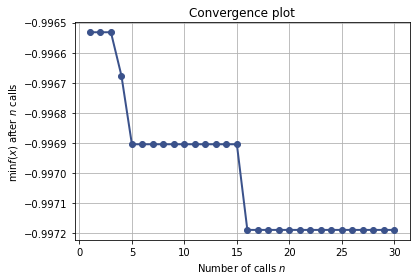

In [35]:
plot_convergence(results["LGBMClassifier"])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

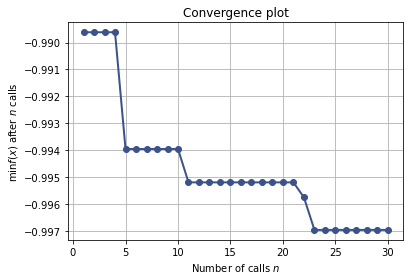

In [36]:
plot_convergence(results["TABNETClassifier"])

In [37]:
results["LGBMClassifier"].x

[0.1911040149797038, 6, 875]

In [38]:
results["XGBClassifier"].x

[0.103989684658078, 5, 805]

In [16]:
results["TABNETClassifier"].x

[1.0131059206061017, 0.0051151725754103195, 10, 54]

In [39]:
for dataset in datasets:
    print("Dataset:", dataset)
    for classifier in classificators:
        with open("{}_hp_kdd_{}.pickle".format(classifier[0], dataset), "rb") as f:
            params = pickle.load(f)
            print('\t' + classifier[0], params)

Dataset: syn1
	LGBMClassifier [0.12084853580348885, 14, 630]
	XGBClassifier [0.6407388649081306, 11, 145]
	TABNETClassifier [1.8294789242800777, 0.024825767831183742, 3, 8, 0.7]
Dataset: syn2
	LGBMClassifier [0.23995731404370924, 13, 483]
	XGBClassifier [0.29615234675507385, 12, 386]
	TABNETClassifier [1.0726430938336577, 0.033960576396166633, 5, 32, 0.7]
Dataset: syn3
	LGBMClassifier [0.4540837973031734, 3, 315]
	XGBClassifier [0.8880765022899698, 4, 675]
	TABNETClassifier [1.5677018396290885, 0.04841913603075304, 4, 32, 0.6]
Dataset: syn4
	LGBMClassifier [0.2618422323665017, 11, 965]
	XGBClassifier [0.3535422004334621, 7, 969]
	TABNETClassifier [1.0840374047235146, 0.07756898575730785, 8, 16, 0.6]
Dataset: syn5
	LGBMClassifier [0.14244374976727375, 5, 198]
	XGBClassifier [0.437344281810245, 5, 920]
	TABNETClassifier [1.1227966185155351, 0.05232096763520789, 4, 24, 0.7]
Dataset: syn6
	LGBMClassifier [0.1911040149797038, 6, 875]
	XGBClassifier [0.103989684658078, 5, 805]
	TABNETClassif